# Sieć Optyczna - Przeszukiwanie i optymalizacja 2025Z
### Maciej Bogusławski 331362, Hubert Kaczyński 331386

## Krótkie streszczenie założeń z Projektu Wstępnego

### Cel projektu
Implementacja programu wykorzystującego algorytm ewolucyjny do znalezienia optymalnego rozłożenia transponderów w sieci optycznej, minimalizującego koszt przy spełnieniu wszystkich wymagań przepustowości.

### Dostępne typy transponderów
- TP1: 10 Gb / koszt 1
- TP2: 40 Gb / koszt 3
- TP3: 100 Gb / koszt 7
- TP4: 200 Gb / koszt 12

### Ograniczenie lambda (maksymalna ilość transponderów na krawędź)
Z początku maksymalna ilość połączeń transponderów korzystających z jednej krawędzi sieci była odgórnie ustawiona na 32, 64, 96. Do implementacji zadania zostały wybrane dwie sieci - "polska" (mniej skomplikowana) i "pioro40" (bardziej skomplikowana). Losowa generacja osobników uniemożliwiła spełnienie żądań tych sieci przy jednoczesnym zmieszczeniu się w zadanych wartościach lambda. Z tego powodu po konsultacjach i wstępnych eksperymentach wartość lambda została zwiększona dla danych sieci "polska" do 120, 240, 360, a dla danych sieci "pioro40" do 2000, 4000, 6000.

### Reprezentacja problemu
Sieć optyczna modelowana jest jako graf, gdzie węzły reprezentują miasta, a krawędzie to połączenia światłowodowe. Transpondery są rozstawiane parami na początku i końcu wybranej ścieżki między dwoma węzłami. Dane wejściowe pochodzą z bazy SNDlib w formacie tekstowym.

### Ograniczenia i cele optymalizacji
- Spełnienie zapotrzebowania: każde żądanie musi otrzymać wymaganą przepustowość
- Limit lambda: maksymalna liczba połączeń przechodzących przez pojedynczą krawędź sieci
- Minimalizacja kosztu: suma kosztów wszystkich użytych transponderów

### Algorytm ewolucyjny - kluczowe operatory
- Generacja populacji: losowe przypisanie ścieżek i liczności transponderów dla każdego żądania
- Funkcja przystosowania: suma kosztu transponderów + kary za naruszenie ograniczeń
- Selekcja turniejowa: wybór lepszych osobników poprzez pojedynki względem przystosowania
- Krzyżowanie jednopunktowe: wymiana genów (alokacji żądań) między rodzicami poprzez przecięcie chromosomów w losowym punkcie
- Mutacja gaussowska: losowa zmiana liczności transponderów
- Sukcesja elitarna: zachowanie określonego procentu najlepszych osobników między generacjami

### Struktura osobnika (chromosomu)
Osobnik reprezentuje kompletne rozwiązanie jako lista alokacji dla wszystkich żądań. Każda alokacja zawiera wybrane ścieżki, a każda ścieżka ma przypisany słownik określający liczbę transponderów każdego typu.

### Plan eksperymentów
- Porównanie działania dla różnych sieci optycznych
- Analiza wpływu rozmiaru turnieju na jakość rozwiązań
- Badanie wpływu parametrów mutacji gaussowskiej
- Ocena różnych wielkości elity w sukcesji elitarnej

# Implementacja

## Użyte biblioteki zewnętrzne

Poniżej znajdują się zaimportowane biblioteki, które zostały użyte do implementacji losowości, użytecznej reprezentacji danych oraz do efektywnego przedstawienia badań i wniosków z działania algorytmu.

In [1]:
import re
import random
import time
from typing import List, Dict, Tuple
from dataclasses import dataclass
import tempfile
import os
import matplotlib.pyplot as plt

## Reprezentacja rozwiązania

Rozwiązanie problemu optymalizacji sieci optycznej zostało zamodelowane przy użyciu struktury hierarchicznej klas danych. Na poziomie podstawowym zdefiniowano elementy sieci: węzły (`Node`), krawędzie (`Link`) oraz żądania (`Demand`) charakteryzujące się źródłem, celem i wymaganą przepustowością. Dla każdego żądania określono zbiór dopuszczalnych ścieżek (`AdmissiblePath`), z których każda składa się z sekwencji identyfikatorów krawędzi.

W problemie dostępne są cztery typy transponderów (`TransponderType`): TP1 o pojemności 10 jednostek i koszcie 1, TP2 (40 jednostek, koszt 3), TP3 (100 jednostek, koszt 7) oraz TP4 (200 jednostek, koszt 12). Warto zauważyć, że stosunek przepustowość/koszt jest najmniejszy dla TP1 i największy dla TP4.

Rozwiązanie reprezentowane przez klasę `Individual` stanowi kompletną alokację transponderów w sieci. Dla każdego żądania (`DemandAllocation`) wybierane są ścieżki wraz z przypisaniem konkretnych typów i liczności transponderów (`PathTransponderAllocation`). Osobnik oceniany jest na podstawie funkcji dopasowania (`fitness`), przy czym uwzględniane są dwa kluczowe ograniczenia: spełnienie wszystkich żądań (`demand_satisfaction`) oraz nieprzekroczenie limitów pojemności na łączach (`transponder_limits_satisfaction`).

In [2]:
@dataclass
class Node:
    id: str

@dataclass
class Link:
    id: str
    source: str
    target: str

@dataclass
class Demand:
    id: str
    source: str
    target: str
    demand_value: float

@dataclass
class AdmissiblePath:
    path_id: str
    links: List[str]

@dataclass
class DemandPaths:
    demand_id: str
    paths: List[AdmissiblePath]

@dataclass
class TransponderType:
    name: str
    capacity: float
    cost: float

TRANSPONDER_TYPES = [
    TransponderType("TP1", 10, 1),
    TransponderType("TP2", 40, 3),
    TransponderType("TP3", 100, 7),
    TransponderType("TP4", 200, 12),
]

@dataclass
class PathTransponderAllocation:
    path_id: str
    transponders: Dict[str, int]  # {transponder_type_name: count}

@dataclass
class DemandAllocation:
    demand_id: str
    selected_paths: List[PathTransponderAllocation]

@dataclass
class Individual:
    """Osobnik w populacji - kompletne rozstawienie transponderów"""
    allocations: List[DemandAllocation]
    fitness: float = float('inf')
    demand_satisfaction: bool = False
    transponder_limits_satisfaction: bool = False

## Parsowanie danych sieciowych w formacie SNDlib

Dane wejściowe problemu są wczytywane z plików w standardzie SNDlib przy użyciu dedykowanej klasy `SNDlibParser`. Parser analizuje strukturę pliku tekstowego, wyodrębniając cztery kluczowe sekcje: węzły sieci (`NODES`), łącza (`LINKS`), żądania (`DEMANDS`) oraz dopuszczalne ścieżki (`ADMISSIBLE_PATHS`).

Proces parsowania wykorzystuje wyrażenia regularne do identyfikacji i ekstrakcji danych z poszczególnych sekcji. W sekcji `NODES` wyodrębniane są identyfikatory węzłów. Sekcja `LINKS` definiuje połączenia między węzłami, określając dla każdego łącza jego identyfikator oraz węzły źródłowy i docelowy. Żądania w sekcji `DEMANDS` charakteryzowane są przez parę węzłów (źródło-cel) oraz wymaganą wartość przepustowości.

Najbardziej złożona jest analiza sekcji `ADMISSIBLE_PATHS`, która dla każdego żądania definiuje zbiór możliwych do wykorzystania ścieżek w sieci. Parser śledzi hierarchiczną strukturę danych, identyfikując początek definicji każdego żądania, następnie wyodrębniając wszystkie przypisane do niego ścieżki wraz z sekwencją łączy, które je tworzą. Wynikiem parsowania jest kompletna reprezentacja topologii sieci oraz przestrzeni rozwiązań, gotowa do wykorzystania przez algorytm ewolucyjny.

In [3]:
class SNDlibParser:
    def __init__(self, filename: str):
        self.filename = filename
        self.nodes: List[Node] = []
        self.links: List[Link] = []
        self.demands: List[Demand] = []
        self.admissible_paths: List[DemandPaths] = []
        
    def parse(self):
        """Parsuje plik SNDlib"""
        with open(self.filename, 'r', encoding='utf-8') as f:
            content = f.read()
        
        self._parse_nodes(content)
        self._parse_links(content)
        self._parse_demands(content)
        self._parse_admissible_paths(content)
        
    def _parse_nodes(self, content: str):
        # Znajdź sekcję NODES
        nodes_start = content.find('NODES (')
        if nodes_start == -1:
            print("Brak sekcji NODES w pliku z danymi sieci.")
            return
        
        # Znajdź koniec sekcji (następna sekcja lub koniec pliku)
        nodes_end = content.find('\n)', nodes_start)
        if nodes_end == -1:
            print("Sekcja NODES nie została poprawnie zakończona w pliku z danymi sieci.")
            return
        
        nodes_text = content[nodes_start:nodes_end]
        
        # Parsuj każdy węzeł
        pattern = r'(\w+)\s*\(\s*([\d.]+)\s+([\d.]+)\s*\)'
        
        for match in re.finditer(pattern, nodes_text):
            node_id = match.group(1)
            self.nodes.append(Node(node_id))
    
    def _parse_links(self, content: str):
        # Znajdź sekcję LINKS
        links_match = re.search(r'LINKS\s*\((.*?)\)(?:\s*# DEMAND)', content, re.DOTALL)
        if not links_match:
            print("Brak poprawnej sekcji LINKS w pliku z danymi sieci.")
            return
        
        # Pobierz i sparsuj każdy link
        links_text = links_match.group(1)
        pattern = r'(\w+)\s*\(\s*(\w+)\s+(\w+)\s*\)\s*([\d.]+)\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)\s*\(\s*(.*?)\s*\)'
        
        for match in re.finditer(pattern, links_text):
            link_id = match.group(1)
            source = match.group(2)
            target = match.group(3)
            
            self.links.append(Link(link_id, source, target))
    
    def _parse_demands(self, content: str):
        # Znajdź sekcję DEMANDS
        demands_match = re.search(r'DEMANDS\s*\((.*?)\)(?:\s*# ADMISSIBLE)', content, re.DOTALL)
        if not demands_match:
            print("Brak poprawnej sekcji DEMANDS w pliku z danymi sieci.")
            return
        
        # Pobierz i sparsuj każdy demand
        demands_text = demands_match.group(1)
        pattern = r'(\w+)\s*\(\s*(\w+)\s+(\w+)\s*\)\s+(\d+)\s+([\d.]+)\s+(\w+)'
        
        for match in re.finditer(pattern, demands_text):
            demand_id = match.group(1)
            source = match.group(2)
            target = match.group(3)
            demand_value = float(match.group(5))
            
            self.demands.append(Demand(demand_id, source, target, demand_value))
    
    def _parse_admissible_paths(self, content: str):
        # Znajdź początek sekcji ADMISSIBLE_PATHS
        paths_start = content.find('ADMISSIBLE_PATHS (')
        if paths_start == -1:
            print("Brak sekcji ADMISSIBLE_PATHS w pliku z danymi sieci.")
            return
        
        # Pobierz całą sekcję do końca pliku
        paths_text = content[paths_start:]
        
        # Znajdź wszystkie definicje demandów
        lines = paths_text.split('\n')
        current_demand = None
        current_paths = []
        in_demand = False
        
        for line in lines:
            line = line.strip()
            
            # Sprawdź czy to początek nowego demandu
            # Format: Demand_X_Y ( lub DX_Y()
            demand_match = re.match(r'(Demand_\d+_\d+|D\d+_\d+)\s*\(', line)
            if demand_match:
                # Zapisz poprzedni demand
                if current_demand and current_paths:
                    self.admissible_paths.append(DemandPaths(current_demand, current_paths))
                
                current_demand = demand_match.group(1)
                current_paths = []
                in_demand = True
                continue
            
            # Jeśli jesteśmy w demandzie, szukaj ścieżek
            if in_demand:
                # Sprawdź czy to koniec demandu
                if line == ')' or line.startswith(')'):
                    if current_demand and current_paths:
                        self.admissible_paths.append(DemandPaths(current_demand, current_paths))
                    current_demand = None
                    current_paths = []
                    in_demand = False
                    continue
                
                # Parsuj ścieżkę: P_X ( Link_A Link_B ... ) lub PX ( LX_Y LX_Y ... )
                path_match = re.match(r'(P_?\d+)\s*\((.*?)\)', line)
                if path_match:
                    path_id = path_match.group(1)
                    links_text = path_match.group(2)
                    links = [link.strip() for link in links_text.split() if link.strip()]
                    current_paths.append(AdmissiblePath(path_id, links))
        
        # Zapisz ostatni demand jeśli istnieje
        if current_demand and current_paths:
            self.admissible_paths.append(DemandPaths(current_demand, current_paths))

## Testy jednostkowe parsera SNDlib

W celu weryfikacji poprawności implementacji parsera przygotowano zestaw testów jednostkowych sprawdzających każdy aspekt procesu wczytywania danych sieciowych. Testy operują na mockowym pliku testowym zawierającym uproszczoną topologię składającą się z 3 węzłów, 3 krawędzi, 2 żądań oraz odpowiadających im ścieżek dopuszczalnych.

Implementacja testów wykorzystuje mechanizm asercji do weryfikacji oczekiwanych wyników w czterech kluczowych obszarach. Test `test_parse_nodes` sprawdza czy parser poprawnie identyfikuje wszystkie węzły sieci oraz zachowuje ich identyfikatory. Test `test_parse_links` weryfikuje ekstrakcję krawędzi wraz z informacjami o węzłach źródłowych i docelowych. Test `test_parse_demands` kontroluje poprawność parsowania żądań, ze szczególnym uwzględnieniem wartości przepustowości. Najbardziej złożony test `test_parse_admissible_paths` analizuje hierarchiczną strukturę ścieżek dopuszczalnych, sprawdzając zarówno liczbę ścieżek dla każdego żądania, jak i składowe sekwencje krawędzi tworzące poszczególne trasy.

Testy wykorzystują mockowy plik tekstowy generowany przed wykonaniem i automatycznie usuwany po zakończeniu. Każdy test wyświetla komunikat o sukcesie lub szczegółowy opis błędu w przypadku niepowodzenia, co ułatwia diagnostykę problemów. Pozytywne przejście wszystkich testów potwierdza, że parser jest gotowy do pracy z rzeczywistymi danymi sieciowymi w formacie SNDlib.

In [5]:
def create_test_file():
    """Tworzy testowy plik SNDlib"""
    test_content = """
NODES (
  N1 ( 10.0 20.0 )
  N2 ( 30.0 40.0 )
  N3 ( 50.0 60.0 )
)

LINKS (
  L1 ( N1 N2 ) 100.0 1.0 10.0 1.0 ( module1 )
  L2 ( N2 N3 ) 150.0 1.0 15.0 1.0 ( module2 )
  L3 ( N1 N3 ) 200.0 1.0 20.0 1.0 ( module3 )
)
# DEMAND SECTION

DEMANDS (
  Demand_1_2 ( N1 N2 ) 50 10.0 UNLIMITED
  Demand_1_3 ( N1 N3 ) 100 15.0 UNLIMITED
)
# ADMISSIBLE PATHS SECTION

ADMISSIBLE_PATHS (
  Demand_1_2 (
    P_1 ( L1 )
  )
  
  Demand_1_3 (
    P_1 ( L3 )
    P_2 ( L1 L2 )
  )
)
"""
    test_file = tempfile.NamedTemporaryFile(mode='w', delete=False, suffix='.txt')
    test_file.write(test_content)
    test_file.close()
    return test_file.name

def test_parse_nodes(parser):
    """Test parsowania węzłów"""
    assert len(parser.nodes) == 3, f"Oczekiwano 3 węzły, otrzymano {len(parser.nodes)}"
    node_ids = [node.id for node in parser.nodes]
    assert 'N1' in node_ids, "Brak węzła N1"
    assert 'N2' in node_ids, "Brak węzła N2"
    assert 'N3' in node_ids, "Brak węzła N3"
    print("Test parsowania węzłów: UDANY")

def test_parse_links(parser):
    """Test parsowania krawędzi"""
    assert len(parser.links) == 3, f"Oczekiwano 3 krawędzie, otrzymano {len(parser.links)}"
    
    link1 = next((link for link in parser.links if link.id == 'L1'), None)
    assert link1 is not None, "Nie znaleziono krawędzi L1"
    assert link1.source == 'N1', f"Błędne źródło dla L1: {link1.source}"
    assert link1.target == 'N2', f"Błędny cel dla L1: {link1.target}"
    
    link2 = next((link for link in parser.links if link.id == 'L2'), None)
    assert link2 is not None, "Nie znaleziono krawędzi L2"
    assert link2.source == 'N2', f"Błędne źródło dla L2: {link2.source}"
    assert link2.target == 'N3', f"Błędny cel dla L2: {link2.target}"
    print("Test parsowania krawędzi: UDANY")

def test_parse_demands(parser):
    """Test parsowania żądań"""
    assert len(parser.demands) == 2, f"Oczekiwano 2 żądania, otrzymano {len(parser.demands)}"
    
    demand1 = next((d for d in parser.demands if d.id == 'Demand_1_2'), None)
    assert demand1 is not None, "Nie znaleziono żądania Demand_1_2"
    assert demand1.source == 'N1', f"Błędne źródło dla Demand_1_2: {demand1.source}"
    assert demand1.target == 'N2', f"Błędny cel dla Demand_1_2: {demand1.target}"
    assert demand1.demand_value == 10.0, f"Błędna wartość dla Demand_1_2: {demand1.demand_value}"
    
    demand2 = next((d for d in parser.demands if d.id == 'Demand_1_3'), None)
    assert demand2 is not None, "Nie znaleziono żądania Demand_1_3"
    assert demand2.source == 'N1', f"Błędne źródło dla Demand_1_3: {demand2.source}"
    assert demand2.target == 'N3', f"Błędny cel dla Demand_1_3: {demand2.target}"
    assert demand2.demand_value == 15.0, f"Błędna wartość dla Demand_1_3: {demand2.demand_value}"
    print("Test parsowania żądań: UDANY")

def test_parse_admissible_paths(parser):
    """Test parsowania dopuszczalnych ścieżek"""
    assert len(parser.admissible_paths) == 2, f"Oczekiwano 2 zestawy ścieżek, otrzymano {len(parser.admissible_paths)}"
    
    demand1_paths = next((demand_path for demand_path in parser.admissible_paths if demand_path.demand_id == 'Demand_1_2'), None)
    assert demand1_paths is not None, "Nie znaleziono ścieżek dla Demand_1_2"
    assert len(demand1_paths.paths) == 1, f"Oczekiwano 1 ścieżkę dla Demand_1_2, otrzymano {len(demand1_paths.paths)}"
    assert demand1_paths.paths[0].path_id == 'P_1', f"Błędne ID ścieżki: {demand1_paths.paths[0].path_id}"
    assert demand1_paths.paths[0].links == ['L1'], f"Błędne krawędzie w ścieżce: {demand1_paths.paths[0].links}"
    
    demand2_paths = next((demand_path for demand_path in parser.admissible_paths if demand_path.demand_id == 'Demand_1_3'), None)
    assert demand2_paths is not None, "Nie znaleziono ścieżek dla Demand_1_3"
    assert len(demand2_paths.paths) == 2, f"Oczekiwano 2 ścieżki dla Demand_1_3, otrzymano {len(demand2_paths.paths)}"
    
    path1 = next((path for path in demand2_paths.paths if path.path_id == 'P_1'), None)
    assert path1 is not None, "Nie znaleziono ścieżki P_1"
    assert path1.links == ['L3'], f"Błędne krawędzie w ścieżce P_1: {path1.links}"
    
    path2 = next((path for path in demand2_paths.paths if path.path_id == 'P_2'), None)
    assert path2 is not None, "Nie znaleziono ścieżki P_2"
    assert path2.links == ['L1', 'L2'], f"Błędne krawędzie w ścieżce P_2: {path2.links}"
    print("Test parsowania dopuszczalnych ścieżek: UDANY")

try:
    test_file_path = create_test_file()
    parser = SNDlibParser(test_file_path)
    parser.parse()
    test_parse_nodes(parser)
    test_parse_links(parser)
    test_parse_demands(parser)
    test_parse_admissible_paths(parser)

    os.unlink(test_file_path)
    
    print("Wszystkie testy udane")
    
except AssertionError as e:
    print(f"Test nieudany: {e}")
except Exception as e:
    print(f"Wystąpił błąd: {e}")

Test parsowania węzłów: UDANY
Test parsowania krawędzi: UDANY
Test parsowania żądań: UDANY
Test parsowania dopuszczalnych ścieżek: UDANY
Wszystkie testy udane


## Generowanie populacji początkowej

Proces inicjalizacji algorytmu ewolucyjnego realizowany jest przez klasę `TransponderPopulationGenerator`, która tworzy populację osobników reprezentujących różne warianty alokacji transponderów w sieci. Każdy osobnik stanowi kompletne rozwiązanie problemu, obejmujące przypisanie transponderów dla wszystkich żądań w sieci.

Generowanie pojedynczego osobnika przebiega w sposób losowy z uwzględnieniem struktury problemu. Dla każdego żądania wybierana jest losowa liczba ścieżek spośród dostępnych ścieżek dopuszczalnych (minimum jedna, maksimum wszystkie dostępne). Następnie dla każdej wybranej ścieżki losowana jest liczba transponderów poszczególnych typów, z zachowaniem górnych limitów określonych przez parametr `max_transponders_per_path`. Proces ten uwzględnia wczesne zatrzymanie – jeśli już przydzielone transpondery spełniają wymagania przepustowości danego żądania, kolejne ścieżki nie są rozpatrywane, co zapobiega generowaniu nadmiarowych alokacji.

Metoda `generate_population` tworzy całą populację początkową poprzez wielokrotne wywołanie generatora pojedynczych osobników. Losowy charakter inicjalizacji zapewnia różnorodność genetyczną populacji, co jest kluczowe dla efektywności algorytmów ewolucyjnych – pozwala na eksplorację różnych regionów przestrzeni rozwiązań i zwiększa prawdopodobieństwo znalezienia globalnego optimum.

In [4]:
class TransponderPopulationGenerator:
    def __init__(self, parser: SNDlibParser, transponder_types: List[TransponderType]):
        self.parser = parser
        self.transponder_types = transponder_types

    def generate_individual(self, max_transponders_per_path) -> Individual:
        """Generuje jednego osobnika (rozstawienie transponderów) dla wszystkich demandów"""
        allocations = []
        
        for demand in self.parser.demands:
            # Znajdź odpowiadające ścieżki dla tego demandu
            demand_paths = next(
                (demand_path for demand_path in self.parser.admissible_paths if demand_path.demand_id == demand.id), 
                None
            )
            
            # Jeśli nie ma ścieżek dla tego demandu, pomiń go
            if not demand_paths or not demand_paths.paths:
                allocations.append(DemandAllocation(demand.id, []))
                continue
            
            # Losowa liczba obsłużonych ścieżek (minimum 1)
            num_paths = random.randint(1, len(demand_paths.paths))
            selected_paths = random.sample(demand_paths.paths, num_paths)
            
            path_allocations = []
            total_capacity = 0
            capacity_met_flag = False
            for path in selected_paths:
                # Sprawdź czy już dodane ścieżki spełniają demand value i nie dodawaj więcej jeśli tak
                for allocation in path_allocations:
                    total_capacity += sum(
                        tp_type.capacity * count
                        for tp_type_name, count in allocation.transponders.items()
                        for tp_type in TRANSPONDER_TYPES
                        if tp_type.name == tp_type_name
                    )
                    if total_capacity >= demand.demand_value:
                        capacity_met_flag = True
                        break
                if capacity_met_flag:
                    capacity_met_flag = False
                    break

                # Dla każdej ścieżki losuj ilość każdego typu transpondera
                transponders = {}
                tp_type1_count = random.randint(0, max_transponders_per_path[0])
                transponders["TP1"] = tp_type1_count
                tp_type2_count = random.randint(0, max_transponders_per_path[1])
                transponders["TP2"] = tp_type2_count
                tp_type3_count = random.randint(0, max_transponders_per_path[2])
                transponders["TP3"] = tp_type3_count
                tp_type4_count = random.randint(0, max_transponders_per_path[3])
                transponders["TP4"] = tp_type4_count
                
                path_allocations.append(
                    PathTransponderAllocation(path.path_id, transponders)
                )
            
            allocations.append(
                DemandAllocation(demand.id, path_allocations)
            )
        
        return Individual(allocations)
    
    def generate_population(self, population_size: int, max_transponders_per_path) -> List[Individual]:
        """Generuje populację osobników"""
        population = []
        for _ in range(population_size):
            individual = self.generate_individual(max_transponders_per_path)
            population.append(individual)
        return population

## Testy jednostkowe generatora populacji

W celu weryfikacji poprawności generowania populacji początkowej przygotowano zestaw testów jednostkowych sprawdzających zarówno strukturalne aspekty pojedynczych osobników, jak i właściwości całej populacji. Testy operują na syntetycznych danych sieciowych i wykorzystują mechanizm asercji do walidacji oczekiwanych zachowań generatora.

Test `test_generate_individual` sprawdza fundamentalne własności osobnika – kompletność alokacji dla wszystkich żądań w sieci oraz poprawność identyfikatorów żądań. Każdy wygenerowany osobnik musi zawierać alokacje odpowiadające wszystkim żądaniom zdefiniowanym w topologii, co gwarantuje, że algorytm ewolucyjny operuje na kompletnych rozwiązaniach. Test `test_transponder_limits` weryfikuje przestrzeganie górnych ograniczeń liczności transponderów na ścieżkach, sprawdzając każdy typ transpondera we wszystkich alokacjach osobnika.

Test `test_generate_population` kontroluje poprawność tworzenia całej populacji, weryfikując czy wygenerowana liczba osobników odpowiada zadanemu parametrowi. Test `test_path_validity` sprawdza krytyczną spójność danych – czy wszystkie identyfikatory ścieżek użyte w alokacjach rzeczywiście istnieją w zbiorze ścieżek dopuszczalnych zdefiniowanych dla sieci. Pozytywne przejście wszystkich testów potwierdza, że generator jest w stanie tworzyć strukturalnie poprawne i spójne populacje osobników, stanowiące punkt wyjścia dla algorytmu ewolucyjnego.

In [7]:
def test_generate_individual(generator, parser, max_tp_per_path):
    """Test generowania pojedynczego osobnika"""
    individual = generator.generate_individual(max_tp_per_path)
    assert len(individual.allocations) == len(parser.demands), f"Osobnik powinien mieć alokacje dla wszystkich {len(parser.demands)} żądań"
    for allocation in individual.allocations:
        assert allocation.demand_id in [demand.id for demand in parser.demands], f"ID żądania {allocation.demand_id} nie istnieje w sieci"
    print("Test generowania pojedynczego osobnika: UDANY")
    return individual

def test_transponder_limits(individual, max_tp_per_path):
    """Test limitów transponderów"""
    for allocation in individual.allocations:
        for path_alloc in allocation.selected_paths:
            assert path_alloc.transponders["TP1"] <= max_tp_per_path[0], f"TP1: {path_alloc.transponders['TP1']} przekracza limit {max_tp_per_path[0]}"
            assert path_alloc.transponders["TP2"] <= max_tp_per_path[1], f"TP2: {path_alloc.transponders['TP2']} przekracza limit {max_tp_per_path[1]}"
            assert path_alloc.transponders["TP3"] <= max_tp_per_path[2], f"TP3: {path_alloc.transponders['TP3']} przekracza limit {max_tp_per_path[2]}"
            assert path_alloc.transponders["TP4"] <= max_tp_per_path[3], f"TP4: {path_alloc.transponders['TP4']} przekracza limit {max_tp_per_path[3]}"
    print("Test limitów transponderów: UDANY")

def test_generate_population(generator, max_tp_per_path):
    """Test generowania populacji"""
    population_size = 10
    population = generator.generate_population(population_size, max_tp_per_path)
    assert len(population) == population_size, f"Populacja powinna mieć {population_size} osobników, ma {len(population)}"
    print(f"Test generowania populacji {population_size} osobników: UDANY")
    return population

def test_path_validity(individual, parser):
    """Test poprawności identyfikatorów ścieżek"""
    all_path_ids = {
        path.path_id 
        for demand_path in parser.admissible_paths 
        for path in demand_path.paths
    }
    for allocation in individual.allocations:
        for path_alloc in allocation.selected_paths:
            assert path_alloc.path_id in all_path_ids, f"Ścieżka {path_alloc.path_id} nie istnieje w zbiorze dopuszczalnych ścieżek"
    print("Test poprawności identyfikatorów ścieżek: UDANY")

try:
    test_file_path = create_test_file()
    parser = SNDlibParser(test_file_path)
    parser.parse()
    
    generator = TransponderPopulationGenerator(parser, TRANSPONDER_TYPES)
    max_tp_per_path = [1, 2, 3, 4]
    
    individual = test_generate_individual(generator, parser, max_tp_per_path)
    test_transponder_limits(individual, max_tp_per_path)
    population = test_generate_population(generator, max_tp_per_path)
    test_path_validity(individual, parser)

    os.unlink(test_file_path)
    
    print("Wszystkie testy udane")
    
except AssertionError as e:
    print(f"Test nieudany: {e}")
except Exception as e:
    print(f"Wystąpił błąd: {e}")

Test generowania pojedynczego osobnika: UDANY
Test limitów transponderów: UDANY
Test generowania populacji 10 osobników: UDANY
Test poprawności identyfikatorów ścieżek: UDANY
Wszystkie testy udane


## Walidacja spełnienia wymagań przepustowości

Funkcja `validate_demand_satisfaction` weryfikuje, czy dany osobnik stanowi dopuszczalne rozwiązanie problemu poprzez sprawdzenie, czy wszystkie żądania w sieci zostały zaspokojone pod względem wymaganej przepustowości. Walidacja ta stanowi kluczowy element oceny osobników w algorytmie ewolucyjnym, pozwalając odróżnić rozwiązania dopuszczalne od niedopuszczalnych.

Proces walidacji przebiega dwuetapowo. W pierwszej fazie dla każdego żądania obliczana jest sumaryczna przepustowość wynikająca z alokacji transponderów na wszystkich wybranych dla niego ścieżkach. Przepustowość pojedynczej ścieżki stanowi suma iloczynów pojemności poszczególnych typów transponderów i ich liczności. W drugiej fazie następuje porównanie zgromadzonej przepustowości z wymaganą wartością żądania (`demand_value`) – jeśli choćby jedno żądanie nie zostało w pełni zaspokojone, osobnik uznawany jest za niespełniający ograniczeń.

Funkcja zwraca wartość logiczną: `True` gdy wszystkie żądania są spełnione, `False` w przeciwnym przypadku. Wynik tej walidacji jest wykorzystywany w funkcji przystosowania do stosowania kar wobec rozwiązań niedopuszczalnych, co kierunkuje proces ewolucji w stronę przestrzeni rozwiązań spełniających wszystkie ograniczenia problemu.

In [5]:
def validate_demand_satisfaction(individual: Individual, parser: SNDlibParser) -> bool:
    """Sprawdza, czy osobnik spełnia wymagania wszystkich demandów."""

    demand_satisfaction = {demand.id: 0.0 for demand in parser.demands}

    for allocation in individual.allocations:
        demand = next((d for d in parser.demands if d.id == allocation.demand_id), None)
        if not demand:
            continue
        
        for path_alloc in allocation.selected_paths:
            # Oblicz całkowitą przepustowość na badanej ścieżce
            path_capacity = sum(
                tp_type.capacity * count
                for tp_type_name, count in path_alloc.transponders.items()
                for tp_type in TRANSPONDER_TYPES
                if tp_type.name == tp_type_name
            )
            demand_satisfaction[demand.id] += path_capacity

    # Sprawdzenie, czy wszystkie demandy są spełnione
    for demand in parser.demands:
        if demand_satisfaction[demand.id] < demand.demand_value:
            return False
    return True

## Testy jednostkowe walidacji spełnienia żądań

W celu weryfikacji poprawności funkcji `validate_demand_satisfaction` przygotowano zestaw testów jednostkowych sprawdzających różne scenariusze alokacji transponderów i ich wpływ na spełnienie wymagań przepustowości żądań. Testy operują na czterech kluczowych przypadkach, które mogą wystąpić podczas działania algorytmu ewolucyjnego.

Test `test_demand_fully_satisfied` weryfikuje pozytywny scenariusz, w którym osobnik dostarcza wystarczającą przepustowość dla wszystkich żądań w sieci. Pierwszy żądanie otrzymuje dokładnie wymaganą przepustowość 10 Gb poprzez jeden transponder TP1, podczas gdy drugie żądanie jest nadprowizjonowane transponderem TP4 o pojemności 200 Gb, znacznie przekraczającym wymagane 15 Gb. Test `test_demand_not_satisfied` sprawdza wykrywanie rozwiązań niedopuszczalnych – osobnik z zerową przepustowością dla pierwszego żądania nie powinien zostać zaakceptowany, nawet jeśli inne żądania są spełnione.

Test `test_demand_multiple_paths` weryfikuje kluczową funkcjonalność agregacji przepustowości z wielu ścieżek realizujących to samo żądanie. Żądanie Demand_1_3 jest obsługiwane przez dwie ścieżki, z których każda dostarcza 10 Gb, co łącznie daje 20 Gb i spełnia wymaganie 15 Gb. Ten scenariusz jest typowy dla rozwiązań optymalnych, gdzie jedno żądanie może być realizowane równolegle przez wiele tras. Test `test_empty_allocations` kontroluje sytuację skrajną – osobnik bez żadnych przydzielonych transponderów oczywiste nie może spełnić żądań i musi być odrzucony. Pozytywne przejście wszystkich testów potwierdza, że funkcja walidacji poprawnie rozróżnia rozwiązania dopuszczalne od niedopuszczalnych.

In [9]:
def test_demand_fully_satisfied(parser):
    """Test dla osobnika spełniającego wszystkie żądania"""
    # (Demand_1_2: 10.0, Demand_1_3: 15.0)
    allocations = [
        DemandAllocation("Demand_1_2", [
            PathTransponderAllocation("P_1", {"TP1": 1, "TP2": 0, "TP3": 0, "TP4": 0})  # 1*10 = 10
        ]),
        DemandAllocation("Demand_1_3", [
            PathTransponderAllocation("P_1", {"TP1": 0, "TP2": 0, "TP3": 0, "TP4": 1})  # 1*200 = 200 > 15
        ])
    ]
    individual = Individual(allocations)
    
    result = validate_demand_satisfaction(individual, parser)
    assert result == True, "Osobnik spełniający wszystkie żądania powinien być zwalidowany pozytywnie"
    print("Test pełnego spełnienia żądań: UDANY")

def test_demand_not_satisfied(parser):
    """Test dla osobnika niespełniającego żądań"""
    allocations = [
        DemandAllocation("Demand_1_2", [
            PathTransponderAllocation("P_1", {"TP1": 0, "TP2": 0, "TP3": 0, "TP4": 0})  # 0
        ]),
        DemandAllocation("Demand_1_3", [
            PathTransponderAllocation("P_1", {"TP1": 0, "TP2": 0, "TP3": 0, "TP4": 1})  # 1*200 = 200 > 15
        ])
    ]
    individual = Individual(allocations)
    
    result = validate_demand_satisfaction(individual, parser)
    assert result == False, "Osobnik niespełniający żądań powinien być zwalidowany negatywnie"
    print("Test niespełnienia żądań: UDANY")

def test_demand_multiple_paths(parser):
    """Test dla osobnika wykorzystującego wiele ścieżek"""
    allocations = [
        DemandAllocation("Demand_1_2", [
            PathTransponderAllocation("P_1", {"TP1": 1, "TP2": 0, "TP3": 0, "TP4": 0})  # 1*10 = 10
        ]),
        DemandAllocation("Demand_1_3", [
            PathTransponderAllocation("P_1", {"TP1": 1, "TP2": 0, "TP3": 0, "TP4": 0}),  # 1*10 = 10
            PathTransponderAllocation("P_2", {"TP1": 1, "TP2": 0, "TP3": 0, "TP4": 0})   # 1*10 = 10, razem 20 > 15
        ])
    ]
    individual = Individual(allocations)
    
    result = validate_demand_satisfaction(individual, parser)
    assert result == True, "Osobnik wykorzystujący wiele ścieżek powinien być zwalidowany pozytywnie"
    print("Test wielościeżkowego spełnienia żądań: UDANY")

def test_empty_allocations(parser):
    """Test dla osobnika z pustymi alokacjami"""
    allocations = [
        DemandAllocation("Demand_1_2", []),
        DemandAllocation("Demand_1_3", [])
    ]
    individual = Individual(allocations)
    
    result = validate_demand_satisfaction(individual, parser)
    assert result == False, "Osobnik z pustymi alokacjami nie powinien spełniać żądań"
    print("Test pustych alokacji: UDANY")

try:
    test_file_path = create_test_file()
    parser = SNDlibParser(test_file_path)
    parser.parse()
    
    test_demand_fully_satisfied(parser)
    test_demand_not_satisfied(parser)
    test_demand_multiple_paths(parser)
    test_empty_allocations(parser)
    
    os.unlink(test_file_path)
    
    print("Wszystkie testy udane")
    
except AssertionError as e:
    print(f"Test nieudany: {e}")
except Exception as e:
    print(f"Wystąpił błąd: {e}")

Test pełnego spełnienia żądań: UDANY
Test niespełnienia żądań: UDANY
Test wielościeżkowego spełnienia żądań: UDANY
Test pustych alokacji: UDANY
Wszystkie testy udane


## Walidacja ograniczeń pojemności krawędzi

Funkcja `validate_transponder_limits` sprawdza drugie kluczowe ograniczenie problemu – nieprzekroczenie maksymalnej liczby transponderów, które mogą jednocześnie operować na pojedynczej krawędzi sieci. Ograniczenie to wynika z fizycznych limitów infrastruktury światłowodowej, gdzie każda krawędź ma określoną pojemność kanałów optycznych.

Walidacja opiera się na zliczaniu współdzielonego użycia krawędzi przez różne ścieżki. Algorytm buduje mapę obciążenia krawędzi, iterując po wszystkich alokacjach transponderów w osobniku. Dla każdej ścieżki, na której umieszczono transpondery, identyfikowane są wszystkie krawędzie wchodzące w jej skład. Każda taka krawędź zwiększa swój licznik obciążenia o łączną liczbę transponderów operujących na danej ścieżce. Kluczową obserwacją jest fakt, że jeśli ścieżka wykorzystuje _n_ transponderów i prowadzi przez _k_ krawędzi, to każda z tych krawędzi musi obsłużyć wszystkie _n_ transponderów.

Funkcja wykorzystuje mechanizm wczesnego przerwania – w momencie wykrycia pierwszej krawędzi przekraczającej limit `max_transponders_per_link`, zwracana jest wartość `False`. Dopiero gdy wszystkie krawędzie zostały sprawdzone i żadna nie przekroczyła limitu, funkcja zwraca `True`. Podobnie jak walidacja spełnienia żądań, wynik tej funkcji wpływa na ocenę przystosowania osobnika i kieruje ewolucją populacji ku rozwiązaniom dopuszczalnym.

In [6]:
def validate_transponder_limits(individual: Individual, parser: SNDlibParser, max_transponders_per_link: int) -> bool:
    link_usage = {}

    # Mapowanie (demand_id, path_id) na listę krawędzi
    path_to_links = {
        (demand_paths.demand_id, path.path_id): path.links for demand_paths in parser.admissible_paths for path in demand_paths.paths
    }

    for allocation in individual.allocations:
        for path_alloc in allocation.selected_paths:
            transponder_count = sum(path_alloc.transponders.values())
            
            if transponder_count == 0:
                continue

            links_in_path = path_to_links.get((allocation.demand_id, path_alloc.path_id), [])

            for link_id in links_in_path:
                link_usage[link_id] = link_usage.get(link_id, 0) + transponder_count

                if link_usage[link_id] > max_transponders_per_link:
                    return False
    
    return True

## Testy jednostkowe walidacji limitów pojemności krawędzi

W celu weryfikacji poprawności funkcji `validate_transponder_limits` przygotowano zestaw testów jednostkowych sprawdzających różne scenariusze obciążenia krawędzi sieciowych przez transpondery. Testy koncentrują się na kluczowym aspekcie problemu – agregacji transponderów z różnych ścieżek współdzielących te same krawędzie oraz wykrywaniu naruszenia limitów pojemności.

Test `test_transponders_within_limit` weryfikuje podstawowy scenariusz pozytywny, gdzie żądania wykorzystują rozłączne zbiory krawędzi (Demand_1_2 używa L1, Demand_1_3 używa L3), przez co nie dochodzi do kumulacji obciążenia. Test `test_transponders_exceed_limit` sprawdza wykrywanie prostego przekroczenia limitu, gdy pojedyncza ścieżka alokuje więcej transponderów niż dozwolone maksimum dla krawędzi. Test `test_transponders_zero_count` kontroluje obsługę przypadku brzegowego – ścieżki bez przypisanych transponderów nie powinny wpływać na obciążenie krawędzi ani powodować błędów walidacji.

Najbardziej istotne są testy współdzielonego użycia krawędzi. Test `test_transponders_shared_links_within_limit` sprawdza scenariusz, w którym dwa żądania używają ścieżek przechodzących przez wspólną krawędź L1 (pierwsze żądanie przez ścieżkę P_1 składającą się z L1, drugie przez ścieżkę P_2 składającą się z L1 i L2), a suma transponderów wynosi 7, co mieści się w limicie 10. Test `test_transponders_shared_links_exceed` weryfikuje wykrywanie przekroczenia limitu w analogicznej sytuacji, gdy suma transponderów na współdzielonej krawędzi L1 wynosi 6, przekraczając ustalony limit 5. Te przypadki testowe są kluczowe dla poprawności algorytmu, ponieważ w rzeczywistych sieciach optycznych krawędzie są intensywnie współdzielone przez wiele ścieżek, a nieprawidłowa agregacja obciążeń prowadziłaby do generowania rozwiązań fizycznie niemożliwych do zrealizowania.

In [11]:
def test_transponders_within_limit(parser):
    """Test dla osobnika nieprzekraczającego limitu transponderów"""
    max_transponders_per_link = 3
    allocations = [
        DemandAllocation("Demand_1_2", [
            PathTransponderAllocation("P_1", {"TP1": 2, "TP2": 1, "TP3": 0, "TP4": 0})  # 3 transpondery
        ]),
        DemandAllocation("Demand_1_3", [
            PathTransponderAllocation("P_1", {"TP1": 1, "TP2": 1, "TP3": 1, "TP4": 0})  # 3 transpondery
        ])
    ]
    individual = Individual(allocations)
    
    result = validate_transponder_limits(individual, parser, max_transponders_per_link)
    assert result == True, "Osobnik nieprzekraczający limitu powinien być zwalidowany pozytywnie"
    print("Test nieprzekroczenia limitu transponderów: UDANY")

def test_transponders_exceed_limit(parser):
    """Test dla osobnika przekraczającego limit transponderów"""
    max_transponders_per_link = 5
    allocations = [
        DemandAllocation("Demand_1_2", [
            PathTransponderAllocation("P_1", {"TP1": 3, "TP2": 3, "TP3": 0, "TP4": 0})  # 6 transponderów na L1 > 5
        ])
    ]
    individual = Individual(allocations)
    
    result = validate_transponder_limits(individual, parser, max_transponders_per_link)
    assert result == False, "Osobnik przekraczający limit powinien być zwalidowany negatywnie"
    print("Test przekroczenia limitu transponderów: UDANY")

def test_transponders_zero_count(parser):
    """Test dla osobnika z brakiem transponderów"""
    max_transponders_per_link = 10
    allocations = [
        DemandAllocation("Demand_1_2", [
            PathTransponderAllocation("P_1", {"TP1": 0, "TP2": 0, "TP3": 0, "TP4": 0})  # 0 transponderów
        ]),
        DemandAllocation("Demand_1_3", [
            PathTransponderAllocation("P_1", {"TP1": 0, "TP2": 0, "TP3": 0, "TP4": 0})  # 0 transponderów
        ])
    ]
    individual = Individual(allocations)
    
    result = validate_transponder_limits(individual, parser, max_transponders_per_link)
    assert result == True, "Osobnik z brakiem transponderów powinien być zwalidowany pozytywnie"
    print("Test zerowej liczby transponderów: UDANY")

def test_transponders_shared_links_within_limit(parser):
    """Test dla osobnika ze współdzielonymi krawędziami"""
    max_transponders_per_link = 10
    # Demand_1_3 ma P_2 (L1, L2) - L1 jest współdzielone z Demand_1_2 P_1 (L1)
    allocations = [
        DemandAllocation("Demand_1_2", [
            PathTransponderAllocation("P_1", {"TP1": 3, "TP2": 0, "TP3": 0, "TP4": 0})  # 3 transpondery na L1
        ]),
        DemandAllocation("Demand_1_3", [
            PathTransponderAllocation("P_2", {"TP1": 4, "TP2": 0, "TP3": 0, "TP4": 0})  # 4 transpondery na L1 i L2
        ])
    ]
    individual = Individual(allocations)
    
    result = validate_transponder_limits(individual, parser, max_transponders_per_link)
    assert result == True, "Osobnik ze współdzielonymi krawędziami poniżej limitu powinien być zwalidowany pozytywnie"
    print("Test współdzielonych krawędzi: UDANY")

def test_transponders_shared_links_exceed(parser):
    """Test dla osobnika ze współdzielonymi krawędziami przekraczającymi limit"""
    max_transponders_per_link = 5
    allocations = [
        DemandAllocation("Demand_1_2", [
            PathTransponderAllocation("P_1", {"TP1": 3, "TP2": 0, "TP3": 0, "TP4": 0})  # 3 transpondery na L1
        ]),
        DemandAllocation("Demand_1_3", [
            PathTransponderAllocation("P_2", {"TP1": 3, "TP2": 0, "TP3": 0, "TP4": 0})  # 3 transpondery na L1 i L2
        ])
    ]
    individual = Individual(allocations)
    
    result = validate_transponder_limits(individual, parser, max_transponders_per_link)
    assert result == False, "Osobnik ze współdzielonymi krawędziami przekraczającymi limit powinien być zwalidowany negatywnie"
    print("Test przekroczenia limitu na współdzielonych krawędziach: UDANY")

try:
    test_file_path = create_test_file()
    parser = SNDlibParser(test_file_path)
    parser.parse()
    
    test_transponders_within_limit(parser)
    test_transponders_exceed_limit(parser)
    test_transponders_zero_count(parser)
    test_transponders_shared_links_within_limit(parser)
    test_transponders_shared_links_exceed(parser)
    
    os.unlink(test_file_path)
    
    print("Wszystkie testy udane")
    
except AssertionError as e:
    print(f"Test nieudany: {e}")
except Exception as e:
    print(f"Wystąpił błąd: {e}")

Test nieprzekroczenia limitu transponderów: UDANY
Test przekroczenia limitu transponderów: UDANY
Test zerowej liczby transponderów: UDANY
Test współdzielonych krawędzi: UDANY
Test przekroczenia limitu na współdzielonych krawędziach: UDANY
Wszystkie testy udane


## Funkcja przystosowania

Funkcja `fitness_function` stanowi kluczowy element algorytmu ewolucyjnego, definiując miarę jakości rozwiązania jako całkowity koszt wdrożenia transponderów w sieci. Celem optymalizacji jest minimalizacja tej funkcji – poszukiwane są rozwiązania o możliwie najniższym koszcie, które jednocześnie spełniają wszystkie ograniczenia problemu.

Funkcja implementuje strategię kar dla rozwiązań niedopuszczalnych. Przed obliczeniem kosztu następuje walidacja dwóch kluczowych ograniczeń: spełnienia wymagań przepustowości wszystkich żądań oraz nieprzekroczenia limitów pojemności krawędzi. Jeśli którekolwiek z tych ograniczeń zostanie naruszone, funkcja zwraca wartość nieskończoną (`float('inf')`), co skutecznie eliminuje takie rozwiązania z procesu selekcji i wymusza ewolucję w kierunku przestrzeni rozwiązań dopuszczalnych.

Dla rozwiązań spełniających ograniczenia koszt jest obliczany jako suma kosztów wszystkich rozmieszczonych transponderów. Każdy typ transpondera charakteryzuje się własnym kosztem jednostkowym, a łączny koszt wynika z iloczynu tego kosztu i liczności transponderów danego typu. Istotnym elementem modelu jest podwojenie kosztu każdego transpondera, co odzwierciedla rzeczywistość technologiczną – w sieciach optycznych transpondery muszą być instalowane na obu końcach każdej ścieżki transmisyjnej, co generuje podwójne nakłady inwestycyjne.

In [7]:
def fitness_function(individual: Individual) -> float:
    """Funkcja celu reprezentująca koszt sieci, która będzie minimalizowana przez algorytm ewolucyjny."""

    total_cost = 0.0
    if individual.demand_satisfaction is False:
        return float('inf')  # Nieskończenie wysoki koszt dla niespełnionych demandów sieci
    if individual.transponder_limits_satisfaction is False:
        return float('inf')  # Nieskończenie wysoki koszt dla przekroczonej ilości transponderów
    
    for allocation in individual.allocations:
        for path_alloc in allocation.selected_paths:
            for tp_type_name, count in path_alloc.transponders.items():
                tp_type = next((tp for tp in TRANSPONDER_TYPES if tp.name == tp_type_name), None)
                if tp_type:
                    total_cost += tp_type.cost * count * 2 # Koszt jest podwajany, ponieważ transponder rozstawiany jest na obu końcach ścieżki
    return total_cost

## Testy jednostkowe funkcji przystosowania

W celu weryfikacji poprawności funkcji `fitness_function` przygotowano zestaw testów jednostkowych sprawdzających zarówno mechanizm kar dla rozwiązań niedopuszczalnych, jak i precyzyjność obliczania kosztu dla rozwiązań spełniających wszystkie ograniczenia. Funkcja przystosowania stanowi rdzeń algorytmu ewolucyjnego, kierując proces selekcji w stronę rozwiązań optymalnych.

Test `test_fitness_valid_solution` weryfikuje podstawowy scenariusz – obliczanie rzeczywistego kosztu dla rozwiązania dopuszczalnego. Dla osobnika spełniającego wszystkie żądania i nieprzekraczającego limitów pojemności, funkcja zwraca sumę kosztów wszystkich transponderów pomnożonych przez 2 (ze względu na instalację na obu końcach ścieżki). Test sprawdza konkretne wartości liczbowe, potwierdzając poprawność formuły kosztowej. Testy `test_fitness_demand_not_satisfied` i `test_fitness_transponder_limit_exceeded` weryfikują mechanizm kar – każde naruszenie ograniczeń (niespełnienie żądań lub przekroczenie limitu transponderów na krawędziach) skutkuje zwróceniem wartości nieskończonej.

Test `test_fitness_multiple_paths` sprawdza złożony scenariusz wykorzystujący wiele typów transponderów oraz wiele ścieżek dla jednego żądania, co odpowiada rzeczywistym rozwiązaniom optymalizacyjnym. Osobnik wykorzystuje wszystkie cztery typy transponderów na pierwszej ścieżce oraz dodatkową ścieżkę dla drugiego żądania, co wymaga precyzyjnej agregacji kosztów z różnych źródeł. Pozytywne przejście wszystkich testów potwierdza, że funkcja przystosowania poprawnie rozróżnia rozwiązania dopuszczalne od niedopuszczalnych oraz dokładnie oblicza jakość rozwiązań w przestrzeni dopuszczalnej.

In [13]:
def test_fitness_valid_solution():
    """Test dla rozwiązania dopuszczalnego"""
    allocations = [
        DemandAllocation("Demand_1_2", [
            PathTransponderAllocation("P_1", {"TP1": 1, "TP2": 0, "TP3": 0, "TP4": 0})  # koszt 1*1*2=2
        ]),
        DemandAllocation("Demand_1_3", [
            PathTransponderAllocation("P_1", {"TP1": 0, "TP2": 0, "TP3": 0, "TP4": 1})  # koszt 1*12*2=24
        ])
    ]
    individual = Individual(allocations, demand_satisfaction=True, transponder_limits_satisfaction=True)
    
    result = fitness_function(individual)
    expected_cost = 2 + 24
    assert result == expected_cost, f"Oczekiwano kosztu {expected_cost}, otrzymano {result}"
    print("Test funkcji przystosowania dla rozwiązania dopuszczalnego: UDANY")

def test_fitness_demand_not_satisfied():
    """Test dla rozwiązania niespełniającego żądań"""
    allocations = [
        DemandAllocation("Demand_1_2", [
            PathTransponderAllocation("P_1", {"TP1": 0, "TP2": 0, "TP3": 0, "TP4": 0})  # 0 Gb < 10 Gb
        ]),
        DemandAllocation("Demand_1_3", [
            PathTransponderAllocation("P_1", {"TP1": 0, "TP2": 0, "TP3": 0, "TP4": 1})  # 200 Gb
        ])
    ]
    individual = Individual(allocations, demand_satisfaction=False, transponder_limits_satisfaction=True)
    
    result = fitness_function(individual)
    assert result == float('inf'), "Rozwiązanie niespełniające żądań powinno mieć koszt nieskończony"
    print("Test funkcji przystosowania dla niespełnionych żądań: UDANY")

def test_fitness_transponder_limit_exceeded():
    """Test dla rozwiązania przekraczającego limit transponderów"""
    allocations = [
        DemandAllocation("Demand_1_2", [
            PathTransponderAllocation("P_1", {"TP1": 2, "TP2": 2, "TP3": 0, "TP4": 0})  # 4 transpondery > 3
        ]),
        DemandAllocation("Demand_1_3", [
            PathTransponderAllocation("P_1", {"TP1": 0, "TP2": 0, "TP3": 0, "TP4": 1})
        ])
    ]
    individual = Individual(allocations, demand_satisfaction=True, transponder_limits_satisfaction=False)
    
    result = fitness_function(individual)
    assert result == float('inf'), "Rozwiązanie przekraczające limit transponderów powinno mieć koszt nieskończony"
    print("Test funkcji przystosowania dla przekroczonego limitu transponderów: UDANY")

def test_fitness_multiple_paths():
    """Test dla wielu ścieżek"""
    allocations = [
        DemandAllocation("Demand_1_2", [
            PathTransponderAllocation("P_1", {"TP1": 1, "TP2": 1, "TP3": 1, "TP4": 1})  # (1+3+7+12)*2 = 46
        ]),
        DemandAllocation("Demand_1_3", [
            PathTransponderAllocation("P_1", {"TP1": 0, "TP2": 0, "TP3": 0, "TP4": 0}),
            PathTransponderAllocation("P_2", {"TP1": 2, "TP2": 0, "TP3": 0, "TP4": 0})  # 2*1*2 = 4
        ])
    ]
    individual = Individual(allocations, demand_satisfaction=True, transponder_limits_satisfaction=True)
    
    result = fitness_function(individual)
    expected_cost = 46 + 4
    assert result == expected_cost, f"Oczekiwano kosztu {expected_cost}, otrzymano {result}"
    print("Test wielu typów transponderów: UDANY")

try:
    test_fitness_valid_solution()
    test_fitness_demand_not_satisfied()
    test_fitness_transponder_limit_exceeded()
    test_fitness_multiple_paths()
    
    print("Wszystkie testy udane")
    
except AssertionError as e:
    print(f"Test nieudany: {e}")
except Exception as e:
    print(f"Wystąpił błąd: {e}")

Test funkcji przystosowania dla rozwiązania dopuszczalnego: UDANY
Test funkcji przystosowania dla niespełnionych żądań: UDANY
Test funkcji przystosowania dla przekroczonego limitu transponderów: UDANY
Test wielu typów transponderów: UDANY
Wszystkie testy udane


## Selekcja turniejowa

Funkcja `tournament_selection` implementuje mechanizm selekcji turniejowej, który jest odpowiedzialny za wybór osobników do reprodukcji. Selekcja turniejowa charakteryzuje się prostotą implementacji oraz dobrą równowagą między eksploracją a eksploatacją przestrzeni rozwiązań - z jednej strony wygrywa lepszy osobnik, ale z drugiej rywale w turnieju wybierani są kompletnie losowo.

Mechanizm działania polega na losowym wyborze określonej liczby osobników z populacji (`tournament_size`), którzy następnie rywalizują między sobą w "turnieju". Zwycięzcą turnieju zostaje osobnik o najniższym koszcie (najlepszym przystosowaniu), ponieważ problem ma charakter minimalizacyjny. Rozmiar turnieju kontroluje presję selekcyjną – mniejsze turnieje (np. 2-3 osobniki) faworyzują eksplorację, dając szansę słabszym osobnikom, podczas gdy większe turnieje intensyfikują eksploatację, preferując najlepsze rozwiązania.

Zaletą selekcji turniejowej jest jej odporność na skalę wartości funkcji przystosowania oraz brak konieczności dodatkowych obliczeń prawdopodobieństw selekcji. Metoda ta naturalnie radzi sobie z wartościami nieskończonymi przypisywanymi rozwiązaniom niedopuszczalnym – takie osobniki zawsze przegrywają turniej z rozwiązaniami dopuszczalnymi.

In [8]:
def tournament_selection(population: List[Individual], tournament_size: int) -> Individual:
    """Selekcja turniejowa"""
    tournament = random.sample(population, tournament_size)
    tournament.sort(key=lambda ind: ind.fitness)
    return tournament[0]

## Testy jednostkowe selekcji turniejowej

W celu weryfikacji poprawności funkcji `tournament_selection` przygotowano zestaw testów jednostkowych sprawdzających jego kluczowe właściwości.

Test `test_tournament_typical_scenario` weryfikuje podstawowy mechanizm działania – w turnieju obejmującym wszystkich trzech osobników z populacji o zróżnicowanych wartościach przystosowania (100.0, 50.0, 75.0) zwycięzcą zawsze powinien zostać osobnik o najniższym koszcie (50.0), ponieważ minimalizujemy funkcję celu. Test `test_tournament_selection_size_one` sprawdza przypadek brzegowy turnieju jednoelementowego, który w praktyce redukuje się do losowego wyboru i eliminuje całkowicie presję selekcyjną. Test `test_tournament_selection_returns_individual` kontroluje poprawność typów danych – funkcja musi zwracać obiekt typu `Individual` należący do oryginalnej populacji, a nie kopię czy nowy obiekt.

Szczególnie istotny jest test `test_tournament_selection_infinite_fitness`, który weryfikuje obsługę rozwiązań niedopuszczalnych posiadających wartość przystosowania równą nieskończoności. W populacji zawierającej dwa osobniki niedopuszczalne (fitness = ∞) i jeden dopuszczalny (fitness = 50.0), selekcja turniejowa powinna zawsze wybrać osobnika dopuszczalnego. Pozytywne przejście testów gwarantuje, że operator selekcji poprawnie faworyzuje lepsze rozwiązania i jest odporny na obecność osobników niedopuszczalnych w populacji.

In [15]:
def test_tournament_typical_scenario():
    """Test typowego scenariusza działania selekcji turniejowej"""
    allocations = [DemandAllocation("Demand_1_2", [])]
    
    ind1 = Individual(allocations)
    ind1.fitness = 100.0
    
    ind2 = Individual(allocations)
    ind2.fitness = 50.0
    
    ind3 = Individual(allocations)
    ind3.fitness = 75.0
    
    population = [ind1, ind2, ind3]
    
    selected = tournament_selection(population, 3)
    assert selected.fitness == 50.0, f"Oczekiwano przystosowanie 50.0, otrzymano {selected.fitness}"
    print("Test podstawowej selekcji turniejowej: UDANY")

def test_tournament_selection_size_one():
    """Test dla turnieju rozmiaru 1"""
    allocations = [DemandAllocation("Demand_1_2", [])]
    
    ind1 = Individual(allocations)
    ind1.fitness = 100.0
    
    ind2 = Individual(allocations)
    ind2.fitness = 50.0
    
    population = [ind1, ind2]
    
    # Turniej rozmiaru 1 zwraca losowego osobnika
    selected = tournament_selection(population, 1)
    assert selected in population, "Wybrany osobnik powinien należeć do populacji"
    print("Test turnieju rozmiaru 1: UDANY")

def test_tournament_selection_returns_individual():
    """Test czy zwraca obiekt typu Individual"""
    allocations = [DemandAllocation("Demand_1_2", [])]
    
    population = []
    for i in range(5):
        ind = Individual(allocations)
        ind.fitness = float(i * 20)
        population.append(ind)
    
    selected = tournament_selection(population, 3)
    assert isinstance(selected, Individual), "Zwrócony obiekt powinien być typu Individual"
    assert selected in population, "Zwrócony osobnik powinien być z oryginalnej populacji"
    print("Test zwracania obiektu Individual: UDANY")

def test_tournament_selection_infinite_fitness():
    """Test dla osobników z nieskończonym przystosowaniem"""
    allocations = [DemandAllocation("Demand_1_2", [])]

    ind1 = Individual(allocations)
    ind1.fitness = float('inf')
    
    ind2 = Individual(allocations)
    ind2.fitness = 50.0
    
    ind3 = Individual(allocations)
    ind3.fitness = float('inf')
    
    population = [ind1, ind2, ind3]
    
    selected = tournament_selection(population, 3)
    assert selected.fitness == 50.0, f"Oczekiwano przystosowanie 50.0, otrzymano {selected.fitness}"
    print("Test selekcji z nieskończonym przystosowaniem: UDANY")

try:
    test_tournament_typical_scenario()
    test_tournament_selection_size_one()
    test_tournament_selection_returns_individual()
    test_tournament_selection_infinite_fitness()
    
    print("Wszystkie testy udane")
    
except AssertionError as e:
    print(f"Test nieudany: {e}")
except Exception as e:
    print(f"Wystąpił błąd: {e}")

Test podstawowej selekcji turniejowej: UDANY
Test turnieju rozmiaru 1: UDANY
Test zwracania obiektu Individual: UDANY
Test selekcji z nieskończonym przystosowaniem: UDANY
Wszystkie testy udane


## Krzyżowanie jednopunktowe

Funkcja `one_point_crossover` implementuje operator krzyżowania jednopunktowego, który umożliwia wymianę materiału genetycznego między dwoma osobnikami rodzicielskimi w celu utworzenia potomstwa. Krzyżowanie stanowi kluczowy mechanizm rekombinacji w algorytmach ewolucyjnych, pozwalający na łączenie korzystnych cech różnych rozwiązań i eksplorację nowych obszarów przestrzeni poszukiwań.

Mechanizm działania polega na losowym wyborze punktu podziału w strukturze osobnika, który następnie dzieli listę alokacji żądań na dwie części. Pierwszy potomek dziedziczy alokacje przed punktem podziału od pierwszego rodzica oraz alokacje po punkcie podziału od drugiego rodzica. Drugi potomek otrzymuje pozostałą kombinację – początkowy fragment od drugiego rodzica i końcowy od pierwszego. Punkt podziału jest wybierany z zakresu od 1 do n-1, gdzie n to liczba żądań, co gwarantuje, że oba potomstwo otrzymają niepusty fragment od każdego z rodziców.

Operator ten zachowuje strukturę hierarchiczną rozwiązania, gdzie każda alokacja odpowiada konkretnemu żądaniu w sieci. Krzyżowanie na poziomie całych alokacji żądań (a nie pojedynczych ścieżek czy transponderów) zapewnia, że potomstwo dziedziczy kompletne strategie obsługi poszczególnych żądań od swoich rodziców. Taka reprezentacja sprzyja dziedziczeniu sensownych kombinacji rozwiązań cząstkowych, co zwiększa prawdopodobieństwo powstania potomstwa o lepszym przystosowaniu.

In [9]:
def one_point_crossover(parent1: Individual, parent2: Individual) -> Tuple[Individual, Individual]:
    """Jednopunktowe krzyżowanie między dwoma osobnikami"""
    point = random.randint(1, len(parent1.allocations) - 1)
    
    child1_allocations = parent1.allocations[:point] + parent2.allocations[point:]
    child2_allocations = parent2.allocations[:point] + parent1.allocations[point:]
    
    return Individual(child1_allocations), Individual(child2_allocations)

## Testy jednostkowe operatora krzyżowania jednopunktowego

W celu weryfikacji poprawności działania funkcji `one_point_crossover` przygotowano zestaw testów jednostkowych sprawdzających podstawowe własności operatora krzyżowania.

Test `test_crossover_returns_two_children` weryfikuje, czy funkcja krzyżowania zwraca dokładnie dwoje potomków oraz czy oba obiekty są poprawnego typu `Individual`. Test `test_crossover_preserves_length` sprawdza, czy długość listy alokacji u potomków jest identyczna jak u obu rodziców, co jest kluczowe dla zachowania spójności reprezentacji rozwiązania.

Test `test_crossover_children_differ` kontroluje, czy krzyżowanie faktycznie prowadzi do powstania nowej kombinacji genów – przynajmniej jeden z potomków powinien różnić się od obu rodziców. Zapobiega to sytuacji, w której operator krzyżowania nie wprowadza żadnej zmienności do populacji.

Test `test_crossover_structure_preservation` weryfikuje, czy struktura danych rozwiązania zostaje zachowana po krzyżowaniu, w szczególności czy wszystkie alokacje w potomkach są obiektami typu `DemandAllocation`. Ostatni test, `test_crossover_demand_ids_preserved`, sprawdza, czy identyfikatory żądań są poprawnie zachowane u potomków, co gwarantuje zgodność rozwiązań po krzyżowaniu.

Pozytywne przejście wszystkich testów potwierdza, że operator krzyżowania jednopunktowego działa poprawnie, zachowuje strukturę danych i generuje nowe, poprawne osobniki w populacji.

In [17]:
def test_crossover_returns_two_children():
    """Test czy krzyżowanie zwraca dwoje potomków"""
    allocations1 = [
        DemandAllocation("Demand_1_2", [PathTransponderAllocation("P_1", {"TP1": 1, "TP2": 0, "TP3": 0, "TP4": 0})]),
        DemandAllocation("Demand_1_3", [PathTransponderAllocation("P_1", {"TP1": 2, "TP2": 0, "TP3": 0, "TP4": 0})])
    ]
    allocations2 = [
        DemandAllocation("Demand_1_2", [PathTransponderAllocation("P_1", {"TP1": 3, "TP2": 0, "TP3": 0, "TP4": 0})]),
        DemandAllocation("Demand_1_3", [PathTransponderAllocation("P_1", {"TP1": 4, "TP2": 0, "TP3": 0, "TP4": 0})])
    ]
    
    parent1 = Individual(allocations1)
    parent2 = Individual(allocations2)
    
    child1, child2 = one_point_crossover(parent1, parent2)
    
    assert isinstance(child1, Individual), "Pierwszy potomek powinien być typu Individual"
    assert isinstance(child2, Individual), "Drugi potomek powinien być typu Individual"
    print("Test zwracania dwojga potomków: UDANY")

def test_crossover_preserves_length():
    """Test czy potomkowie mają taką samą długość jak rodzice"""
    allocations1 = [
        DemandAllocation("Demand_1_2", []),
        DemandAllocation("Demand_1_3", []),
        DemandAllocation("Demand_1_4", [])
    ]
    allocations2 = [
        DemandAllocation("Demand_1_2", []),
        DemandAllocation("Demand_1_3", []),
        DemandAllocation("Demand_1_4", [])
    ]
    
    parent1 = Individual(allocations1)
    parent2 = Individual(allocations2)
    
    child1, child2 = one_point_crossover(parent1, parent2)
    
    assert len(child1.allocations) == len(parent1.allocations), "Potomek 1 powinien mieć taką samą długość jak rodzice"
    assert len(child1.allocations) == len(parent2.allocations), "Potomek 1 powinien mieć taką samą długość jak rodzice"
    assert len(child2.allocations) == len(parent1.allocations), "Potomek 2 powinien mieć taką samą długość jak rodzice"
    assert len(child2.allocations) == len(parent2.allocations), "Potomek 2 powinien mieć taką samą długość jak rodzice"
    print("Test zachowania długości: UDANY")

def test_crossover_children_differ():
    """Test czy potomkowie różnią się od rodziców"""
    allocations1 = [
        DemandAllocation("Demand_1_2", [PathTransponderAllocation("P_1", {"TP1": 1, "TP2": 0, "TP3": 0, "TP4": 0})]),
        DemandAllocation("Demand_1_3", [PathTransponderAllocation("P_1", {"TP1": 1, "TP2": 0, "TP3": 0, "TP4": 0})])
    ]
    allocations2 = [
        DemandAllocation("Demand_1_2", [PathTransponderAllocation("P_1", {"TP1": 5, "TP2": 0, "TP3": 0, "TP4": 0})]),
        DemandAllocation("Demand_1_3", [PathTransponderAllocation("P_1", {"TP1": 5, "TP2": 0, "TP3": 0, "TP4": 0})])
    ]
    
    parent1 = Individual(allocations1)
    parent2 = Individual(allocations2)
    
    child1, child2 = one_point_crossover(parent1, parent2)
    
    child1_str = str([(a.demand_id, a.selected_paths) for a in child1.allocations])
    child2_str = str([(a.demand_id, a.selected_paths) for a in child2.allocations])
    parent1_str = str([(a.demand_id, a.selected_paths) for a in parent1.allocations])
    parent2_str = str([(a.demand_id, a.selected_paths) for a in parent2.allocations])
    
    # Przynajmniej jeden potomek powinien różnić się od obu rodziców
    assert (child1_str != parent1_str and child1_str != parent2_str) or (child2_str != parent1_str and child2_str != parent2_str), "Przynajmniej jeden potomek powinien być nową kombinacją"
    print("Test zróżnicowania potomków: UDANY")

def test_crossover_structure_preservation():
    """Test czy zachowana jest struktura alokacji"""
    allocations1 = [
        DemandAllocation("Demand_1_2", [PathTransponderAllocation("P_1", {"TP1": 1, "TP2": 0, "TP3": 0, "TP4": 0})]),
        DemandAllocation("Demand_1_3", [PathTransponderAllocation("P_2", {"TP1": 2, "TP2": 0, "TP3": 0, "TP4": 0})])
    ]
    allocations2 = [
        DemandAllocation("Demand_1_2", [PathTransponderAllocation("P_1", {"TP1": 3, "TP2": 0, "TP3": 0, "TP4": 0})]),
        DemandAllocation("Demand_1_3", [PathTransponderAllocation("P_2", {"TP1": 4, "TP2": 0, "TP3": 0, "TP4": 0})])
    ]
    
    parent1 = Individual(allocations1)
    parent2 = Individual(allocations2)
    
    child1, child2 = one_point_crossover(parent1, parent2)
    
    for allocation in child1.allocations:
        assert isinstance(allocation, DemandAllocation), "Wszystkie alokacje w potomku 1 powinny być typu DemandAllocation"
    
    for allocation in child2.allocations:
        assert isinstance(allocation, DemandAllocation), "Wszystkie alokacje w potomku 2 powinny być typu DemandAllocation"
    
    print("Test zachowania struktury alokacji: UDANY")

def test_crossover_demand_ids_preserved():
    """Test czy ID żądań są zachowane u potomków"""
    allocations1 = [
        DemandAllocation("Demand_1_2", []),
        DemandAllocation("Demand_1_3", [])
    ]
    allocations2 = [
        DemandAllocation("Demand_1_2", []),
        DemandAllocation("Demand_1_3", [])
    ]
    
    parent1 = Individual(allocations1)
    parent2 = Individual(allocations2)
    
    child1, child2 = one_point_crossover(parent1, parent2)
    
    # Zbierz ID żądań od rodziców i potomków
    parent_demand_ids = {a.demand_id for a in parent1.allocations}
    child1_demand_ids = {a.demand_id for a in child1.allocations}
    child2_demand_ids = {a.demand_id for a in child2.allocations}
    
    assert child1_demand_ids == parent_demand_ids, "Potomek 1 powinien mieć te same ID żądań co rodzice"
    assert child2_demand_ids == parent_demand_ids, "Potomek 2 powinien mieć te same ID żądań co rodzice"
    print("Test zachowania ID żądań: UDANY")

try:
    test_crossover_returns_two_children()
    test_crossover_preserves_length()
    test_crossover_children_differ()
    test_crossover_structure_preservation()
    test_crossover_demand_ids_preserved()
    
    print("Wszystkie testy udane")
    
except AssertionError as e:
    print(f"Test nieudany: {e}")
except Exception as e:
    print(f"Wystąpił błąd: {e}")

Test zwracania dwojga potomków: UDANY
Test zachowania długości: UDANY
Test zróżnicowania potomków: UDANY
Test zachowania struktury alokacji: UDANY
Test zachowania ID żądań: UDANY
Wszystkie testy udane


## Mutacja gaussowska

Funkcja `gaussian_mutation` implementuje operator mutacji oparty na rozkładzie normalnym (gaussowskim), który wprowadza losowe modyfikacje do osobnika w celu utrzymania różnorodności genetycznej populacji i umożliwienia eksploracji nowych obszarów przestrzeni rozwiązań.

Operator działa na poziomie pojedynczych transponderów w alokacjach osobnika. Dla każdego typu transpondera na każdej wybranej ścieżce, z prawdopodobieństwem określonym przez parametr `mutation_rate`, wykonywana jest modyfikacja jego liczności. Zmiana jest generowana z rozkładu normalnego o średniej zero i odchyleniu standardowym równym `mutation_strength`, co oznacza, że małe zmiany są bardziej prawdopodobne niż duże skoki. Wartość mutacji jest zaokrąglana do liczby całkowitej i dodawana do aktualnej liczby transponderów, przy czym wynik jest ograniczony od dołu do zera, co zapobiega powstaniu niedopuszczalnych wartości ujemnych.

Parametry `mutation_rate` i `mutation_strength` kontrolują intensywność mutacji. Niski `mutation_rate` (np. 0.1) powoduje, że mutacji podlega jedynie niewielka część genów, podczas gdy wyższe wartości zwiększają zakres modyfikacji. Parametr `mutation_strength` określa skalę zmian – małe wartości (np. 1-2) prowadzą do subtelnych dostrojczeń liczby transponderów, większe (np. 5-10) umożliwiają bardziej radykalne zmiany konfiguracji.

In [10]:
def gaussian_mutation(individual: Individual, mutation_rate: float, mutation_strength: float):
    """Mutacja Gaussowska na osobniku"""
    for allocation in individual.allocations:
        for path_alloc in allocation.selected_paths:
            for tp_type_name in path_alloc.transponders.keys():
                if random.random() < mutation_rate:
                    current_value = path_alloc.transponders[tp_type_name]
                    mutation = int(random.gauss(0, mutation_strength))
                    new_value = max(0, current_value + mutation)
                    path_alloc.transponders[tp_type_name] = new_value

## Testy jednostkowe mutacji Gaussowskiej

W celu weryfikacji poprawności działania funkcji `gaussian_mutation` przygotowano zestaw testów jednostkowych sprawdzających kluczowe własności operatora mutacji.

Test `test_gaussian_mutation_no_change_when_rate_zero` sprawdza, czy przy zerowym współczynniku mutacji (`mutation_rate = 0`) wartości transponderów pozostają niezmienione. Test `test_gaussian_mutation_no_negative_values` weryfikuje, czy mutacja nigdy nie prowadzi do powstania wartości ujemnych.

Test `test_gaussian_mutation_applies_change` kontroluje, czy mutacja faktycznie wprowadza zmiany w wartościach transponderów przy maksymalnym współczynniku mutacji (`mutation_rate = 1.0`) i dużej sile mutacji, zapewniając generowanie różnorodnych rozwiązań (jest tu mała szansa na niepowodzenie testu, ale jest to poprawne działanie). Natomiast `test_gaussian_mutation_structure_preserved` sprawdza, czy struktura alokacji pozostaje nienaruszona po mutacji, w tym typy obiektów i zestaw kluczy transponderów.

Pozytywne przejście wszystkich testów potwierdza, że operator mutacji Gaussowskiej działa poprawnie, wprowadza zmienność do populacji, zachowuje integralność danych i przestrzega ograniczeń dopuszczalnych wartości.

In [19]:
def test_gaussian_mutation_no_change_when_rate_zero():
    """Test czy mutacja nie zmienia wartości przy mutation_rate = 0"""
    allocations = [
        DemandAllocation("Demand_1_2", [PathTransponderAllocation("P_1", {"TP1": 1, "TP2": 0, "TP3": 0, "TP4": 0})])
    ]
    individual = Individual(allocations)

    original = individual.allocations[0].selected_paths[0].transponders.copy()

    gaussian_mutation(individual, mutation_rate=0.0, mutation_strength=10)

    mutated = individual.allocations[0].selected_paths[0].transponders
    assert mutated == original, "Wartości nie powinny się zmienić przy mutation_rate = 0"

    print("Test mutation_rate = 0 nic nie zmienia: UDANY")

def test_gaussian_mutation_no_negative_values():
    """Test czy mutacja nie powoduje wartości ujemnych"""
    allocations = [
        DemandAllocation("Demand_1_2", [PathTransponderAllocation("P_1", {"TP1": 0, "TP2": 0, "TP3": 0, "TP4": 0})])
    ]
    individual = Individual(allocations)

    gaussian_mutation(individual, mutation_rate=1.0, mutation_strength=10)

    value_1 = individual.allocations[0].selected_paths[0].transponders["TP1"]
    value_2 = individual.allocations[0].selected_paths[0].transponders["TP2"]
    value_3 = individual.allocations[0].selected_paths[0].transponders["TP3"]
    value_4 = individual.allocations[0].selected_paths[0].transponders["TP4"]
    assert value_1 >= 0, "Wartość transpondera 1 nie powinna być ujemna"
    assert value_2 >= 0, "Wartość transpondera 2 nie powinna być ujemna"
    assert value_3 >= 0, "Wartość transpondera 3 nie powinna być ujemna"
    assert value_4 >= 0, "Wartość transpondera 4 nie powinna być ujemna"

    print("Test braku wartości ujemnych: UDANY")

def test_gaussian_mutation_applies_change():
    """Test czy mutacja poprawnie zmienia wartości transponderów"""
    allocations = [
        DemandAllocation("Demand_1_2", [PathTransponderAllocation("P_1", {"TP1": 10, "TP2": 1, "TP3": 2, "TP4": 5})])
    ]
    individual = Individual(allocations)

    gaussian_mutation(individual, mutation_rate=1.0, mutation_strength=100000)

    value_1 = individual.allocations[0].selected_paths[0].transponders["TP1"]
    value_2 = individual.allocations[0].selected_paths[0].transponders["TP2"]
    value_3 = individual.allocations[0].selected_paths[0].transponders["TP3"]
    value_4 = individual.allocations[0].selected_paths[0].transponders["TP4"]
    assert value_1 != 10, "Wartość transpondera 1 powinna ulec zmianie przy mutation_rate = 1"
    assert value_2 != 1, "Wartość transpondera 2 powinna ulec zmianie przy mutation_rate = 1"
    assert value_3 != 2, "Wartość transpondera 3 powinna ulec zmianie przy mutation_rate = 1"
    assert value_4 != 5, "Wartość transpondera 4 powinna ulec zmianie przy mutation_rate = 1"

    print("Test wymuszonej mutacji: UDANY")

def test_gaussian_mutation_structure_preserved():
    """Test czy struktura alokacji jest zachowana po mutacji"""
    allocations = [
        DemandAllocation("Demand_1_2", [PathTransponderAllocation("P_1", {"TP1": 10, "TP2": 1, "TP3": 2, "TP4": 5})])
    ]
    individual = Individual(allocations)

    gaussian_mutation(individual, mutation_rate=1.0, mutation_strength=3)

    allocation = individual.allocations[0]
    path_alloc = allocation.selected_paths[0]

    assert isinstance(allocation, DemandAllocation)
    assert isinstance(path_alloc, PathTransponderAllocation)
    assert set(path_alloc.transponders.keys()) == {"TP1", "TP2", "TP3", "TP4"}

    print("Test zachowania struktury: UDANY")

try:
    test_gaussian_mutation_no_change_when_rate_zero()
    test_gaussian_mutation_no_negative_values()
    test_gaussian_mutation_applies_change()
    test_gaussian_mutation_structure_preserved()
    
    print("Wszystkie testy udane")
    
except AssertionError as e:
    print(f"Test nieudany: {e}")
except Exception as e:
    print(f"Wystąpił błąd: {e}")

Test mutation_rate = 0 nic nie zmienia: UDANY
Test braku wartości ujemnych: UDANY
Test wymuszonej mutacji: UDANY
Test zachowania struktury: UDANY
Wszystkie testy udane


## Sukcesja elitarna

Funkcja `elite_succession` implementuje mechanizm, który zapewnia zachowanie najlepszych osobników z populacji w kolejnych pokoleniach algorytmu ewolucyjnego.

Mechanizm działania – populacja jest sortowana według wartości funkcji przystosowania (rosnąco, ponieważ minimalizujemy koszt), a następnie wybieranych jest `elite_size` pierwszych najlepszych osobników. Ci wyróżnieni osobnicy są automatycznie przepisywani do następnej generacji.

Rozmiar elity (`elite_size`) stanowi kompromis – zbyt mała elita może prowadzić do utraty dobrych rozwiązań, podczas gdy zbyt duża ogranicza różnorodność i może spowolnić eksplorację przestrzeni rozwiązań.

In [11]:
def elite_succession(population: List[Individual], elite_size: int) -> List[Individual]:
    """Zachowanie najlepszych osobników w populacji"""
    sorted_population = sorted(population, key=lambda ind: ind.fitness)
    return sorted_population[:elite_size]

## Testy jednostkowe sukcesji elitarnej

Aby zweryfikować poprawność działania funkcji `elite_succession`, przygotowano zestaw testów jednostkowych sprawdzających jej kluczowe właściwości.

Test `test_elite_succession_returns_correct_size` kontroluje, czy sukcesja elitarna zwraca dokładnie tyle najlepszych osobników, ile określono parametrem `elite_size`. Test `test_elite_succession_selects_best_individuals` weryfikuje, czy funkcja faktycznie wybiera osobników o najlepszych wartościach fitness, czyli tych najkorzystniejszych z punktu widzenia funkcji celu.

Test `test_elite_succession_does_not_modify_population` sprawdza, czy oryginalna populacja pozostaje nienaruszona – funkcja powinna zwracać nową listę elit, nie zmieniając kolejności ani zawartości pierwotnej populacji. Natomiast `test_elite_succession_zero_elite_size` testuje przypadek brzegowy, w którym liczba elit ustawiona jest na 0 – w takim przypadku funkcja powinna zwrócić pustą listę.

Pozytywne przejście wszystkich testów potwierdza, że sukcesja elitarna działa poprawnie, wybiera najlepsze osobniki, zachowuje integralność populacji i obsługuje sytuacje brzegowe.

In [21]:
def test_elite_succession_returns_correct_size():
    """Test czy sukcesja elitarna zwraca poprawną liczbę elit"""
    population = [
        Individual([], fitness=10),
        Individual([], fitness=5),
        Individual([], fitness=1)
    ]

    elites = elite_succession(population, elite_size=2)

    assert len(elites) == 2, "Liczba elit powinna być równa elite_size"
    print("Test liczby elit: UDANY")

def test_elite_succession_selects_best_individuals():
    """Test czy sukcesja elitarna wybiera najlepszych osobników"""
    ind1 = Individual([], fitness=10)
    ind2 = Individual([], fitness=1)
    ind3 = Individual([], fitness=5)

    population = [ind1, ind2, ind3]

    elites = elite_succession(population, elite_size=2)

    assert ind2 in elites, "Osobnik o najlepszym fitness powinien być elitą"
    assert ind3 in elites, "Drugi najlepszy osobnik powinien być elitą"
    print("Test wyboru najlepszych osobników: UDANY")

def test_elite_succession_does_not_modify_population():
    """Test czy sukcesja elitarna nie modyfikuje oryginalnej populacji"""
    population = [
        Individual([], fitness=3),
        Individual([], fitness=1),
        Individual([], fitness=2)
    ]

    original_order = population.copy()

    elite_succession(population, elite_size=2)

    assert population == original_order, "Populacja wejściowa nie powinna być modyfikowana"
    print("Test niemodyfikowania populacji: UDANY")

def test_elite_succession_zero_elite_size():
    """Test czy sukcesja elitarna działa poprawnie przy rozmiarze elity 0"""
    population = [
        Individual([], fitness=1),
        Individual([], fitness=2)
    ]

    elites = elite_succession(population, elite_size=0)

    assert elites == [], "Przy elite_size = 0 lista elit powinna być pusta"
    print("Test elite_size = 0: UDANY")

try:
    test_elite_succession_returns_correct_size()
    test_elite_succession_selects_best_individuals()
    test_elite_succession_does_not_modify_population()
    test_elite_succession_zero_elite_size()

    print("Wszystkie testy udane")

except AssertionError as e:
    print(f"Test nieudany: {e}")
except Exception as e:
    print(f"Wystąpił błąd: {e}")


Test liczby elit: UDANY
Test wyboru najlepszych osobników: UDANY
Test niemodyfikowania populacji: UDANY
Test elite_size = 0: UDANY
Wszystkie testy udane


## Aktualizacja najlepszego rozwiązania

Funkcja `update_best_individual` stanowi pomocniczą procedurę zarządzającą ewaluacją populacji oraz śledzeniem najlepszego dotychczas odkrytego rozwiązania w trakcie działania algorytmu ewolucyjnego. Funkcja ta zapewnia identyfikację globalnie najlepszego rozwiązania (na przestrzeni każdego etapu każdej iteracji algorytmu).

Procedura ewaluacji jest wykonywana w trzech krokach dla każdego osobnika w populacji. Najpierw weryfikowane jest spełnienie ograniczenia przepustowości żądań poprzez funkcję `validate_demand_satisfaction`, następnie sprawdzane są limity pojemności krawędzi za pomocą `validate_transponder_limits`, a na końcu obliczana jest wartość funkcji przystosowania `fitness_function`. Wyniki tych walidacji są zapisywane bezpośrednio w atrybutach osobnika, co umożliwia późniejszą analizę i diagnostykę rozwiązań.

Równolegle z ewaluacją populacji funkcja śledzi najlepsze dotychczas znalezione rozwiązanie. Po obliczeniu przystosowania każdego osobnika następuje porównanie z aktualnym rekordem (`best_fitness`) – jeśli osobnik osiągnął niższy koszt, zostaje zapamiętany jako nowe najlepsze rozwiązanie. Funkcja zwraca zaktualizowaną parę wartości: najniższy koszt oraz odpowiadający mu osobnik. Mechanizm ten jest kluczowy dla monitorowania postępu algorytmu i umożliwia zwrócenie optymalnego rozwiązania po zakończeniu procesu ewolucji.

In [12]:
def update_best_individual(population: List[Individual], parser: SNDlibParser, max_transponders_per_link: int, best_fitness: float, best_individual: Individual) -> Tuple[float, Individual]:
    """Funckja pomocnicza dla algorytmu ewolucyjnego do aktualizacji najlepszego osobnika w populacji i wartości funkcji celu"""
    for individual in population:
        individual.demand_satisfaction = validate_demand_satisfaction(individual, parser)
        individual.transponder_limits_satisfaction = validate_transponder_limits(individual, parser, max_transponders_per_link)
        individual.fitness = fitness_function(individual)
        if individual.fitness < best_fitness:
            best_fitness = individual.fitness
            best_individual = individual
    return best_fitness, best_individual

## Algorytm ewolucyjny

Funkcja `evolution` stanowi główny kod sterujący całym procesem poszukiwania optymalnego rozstawienia transponderów w sieci. Implementuje schemat algorytmu ewolucyjnego, łączący operatory selekcji, krzyżowania, mutacji i sukcesji w iteracyjnym procesie stopniowego doskonalenia populacji rozwiązań. Funkcja przyjmuje kluczowe parametry sterujące zachowaniem algorytmu:

- `max_transponders_per_link` - maksymalna liczba transponderów dopuszczalna na pojedynczej krawędzi sieci,
- `iterations` - liczba generacji algorytmu ewolucyjnego do przetworzenia,
- `population_size` - liczba osobników w populacji w każdej generacji,
- `parser` - obiekt parsera SNDlib, zawierający dane optymalizowanej sieci,
- `tournament_size` - liczba osobników biorących udział w pojedynczym turnieju selekcyjnym,
- `mutation_rate` - prawdopodobieństwo zastosowania mutacji,
- `mutation_strength` - skala zmian wprowadzanych przez mutację,
- `elite_size` - liczba najlepszych osobników, które są zachowywane w kolejnej generacji.

Przed rozpoczęciem ewolucji funkcja wykonuje oszacowanie maksymalnej liczby transponderów każdego typu na ścieżkę, bazując na średnim zapotrzebowaniu w sieci. Dla największego typu transpondera (TP4) obliczana jest minimalna liczba potrzebna do obsłużenia średniego żądania, a następnie proporcjonalnie określane są limity dla mniejszych typów. Tak policzone liczby są jeszcze podwajane, aby zwiększyć szansę na wylosowanie osobników spełniających zapotrzebowanie. To podejście adaptacyjne zapewnia duże prawdopodobieństwo, że populacja początkowa generowana przez `TransponderPopulationGenerator` zawiera rozwiązania o sensownych wartościach. Po inicjalizacji następuje ewaluacja populacji początkowej i identyfikacja najlepszego rozwiązania.

Główna pętla ewolucyjna wykonuje sekwencję czterech etapów w każdej iteracji. Etap selekcji tworzy pośrednią populację wybierając osobniki metodą turniejową. Następnie etap krzyżowania łączy losowe pary rodziców, generując zmieszanych potomków. Etap mutacji wprowadza losowe modyfikacje do wszystkich potomków zgodnie z rozkładem gaussowskim i zadanym prawdopodobieństem. Na końcu odbywa się mechanizm sukcesji – zamiast zastąpienia całej populacji potomstwem, algorytm zachowuje niewielką elitę najlepszych osobników (`elite_size`), a pozostałą część populacji wypełnia zmutowanymi osobnikami. Po każdej iteracji następuje aktualizacja globalnie najlepszego rozwiązania, a po zakończeniu wszystkich iteracji funkcja zwraca optymalne rozstawienie transponderów wraz z jego kosztem.

In [13]:
def evolution(max_transponders_per_link, iterations, population_size, parser, tournament_size, mutation_rate, mutation_strength, elite_size):
    """Główna funkcja algorytmu ewolucyjnego"""
    # Oblicz maksymalną liczbę transponderów na ścieżkę na podstawie średniego zapotrzebowania
    avg_demand = sum(demand.demand_value for demand in parser.demands)/len(parser.demands)
    max_tp4_num = int(avg_demand // (TRANSPONDER_TYPES[3].capacity + 1) + 1)
    max_tp3_num = max_tp4_num * 2 - 1
    max_tp2_num = 2
    max_tp1_num = 1

    # Wygeneruj populację początkową i zmierz jej jakość
    generator = TransponderPopulationGenerator(parser, TRANSPONDER_TYPES)
    population = generator.generate_population(population_size=population_size, max_transponders_per_path=[2*max_tp1_num, 2*max_tp2_num, 2*max_tp3_num, 2*max_tp4_num])
    best_individual = None
    best_fitness = float('inf')
    best_fitness, best_individual = update_best_individual(population, parser, max_transponders_per_link, best_fitness, best_individual)
    
    # Główna pętla algorytmu ewolucyjnego
    for _ in range(iterations):
        # Selekcja
        selected_population = []
        for _ in range(len(population)):
            selected_population.append(tournament_selection(population, tournament_size=tournament_size))
        
        # Krzyżowanie
        crossed_population = []
        for _ in range(len(selected_population) // 2):
            parent1 = random.choice(selected_population)
            parent2 = random.choice(selected_population)
            child1, child2 = one_point_crossover(parent1, parent2)
            crossed_population.append(child1)
            crossed_population.append(child2)
        
        # Mutacja
        mutated_population = []
        for individual in crossed_population:
            gaussian_mutation(individual, mutation_rate=mutation_rate, mutation_strength=mutation_strength)
            mutated_population.append(individual)
        
        # Sukcesja elitarna
        population = elite_succession(population, elite_size=elite_size) + random.sample(mutated_population, population_size - elite_size)
        best_fitness, best_individual = update_best_individual(population, parser, max_transponders_per_link, best_fitness, best_individual)
    
    return best_individual, best_fitness

## Demonstracja działania algorytmu ewolucyjnego – sieć polska.txt

Poniższy test prezentuje końcowy wynik działania algorytmu ewolucyjnego dla sieci polska.txt.
Algorytm uruchamiany jest dla przykładowego zestawu parametrów.

Prezentowane jest poza przystosowaniem szczegółowe rozstawienie transponderów w najlepszym osobniku, z podziałem na żądania i wybrane ścieżki. Dla czytelności wyświetlane jest 20 przypisań.

In [14]:
def evolution_outcome_demonstration_poland():
    parser_poland = SNDlibParser("polska.txt")
    parser_poland.parse()

    best_individual, best_fitness = evolution(max_transponders_per_link=200, iterations=100, population_size=1000, parser=parser_poland, tournament_size=2, mutation_rate=0.05, mutation_strength=0.4, elite_size=10)
    
    if best_fitness == float('inf'):
        print("W tej ewolucji nie znaleziono dopuszczalnego rozwiązania dla pliku Polska.txt")
        return

    print("Polska.txt - Najlepsze przystosowanie:", best_fitness)
    print("Rozstawienie transponderów zawarte w najlepszym osobniku:")
    for allocation in best_individual.allocations[:20]:
        for path_alloc in allocation.selected_paths:
            print(f"Żądanie: {allocation.demand_id}, Ścieżka: {path_alloc.path_id}, Transpondery: {path_alloc.transponders}")

evolution_outcome_demonstration_poland()

Polska.txt - Najlepsze przystosowanie: 2974.0
Rozstawienie transponderów zawarte w najlepszym osobniku:
Żądanie: Demand_0_1, Ścieżka: P_5, Transpondery: {'TP1': 2, 'TP2': 4, 'TP3': 2, 'TP4': 2}
Żądanie: Demand_0_2, Ścieżka: P_6, Transpondery: {'TP1': 11, 'TP2': 0, 'TP3': 3, 'TP4': 0}
Żądanie: Demand_0_3, Ścieżka: P_2, Transpondery: {'TP1': 4, 'TP2': 3, 'TP3': 0, 'TP4': 6}
Żądanie: Demand_0_4, Ścieżka: P_3, Transpondery: {'TP1': 1, 'TP2': 6, 'TP3': 5, 'TP4': 0}
Żądanie: Demand_0_5, Ścieżka: P_6, Transpondery: {'TP1': 0, 'TP2': 0, 'TP3': 2, 'TP4': 0}
Żądanie: Demand_0_6, Ścieżka: P_2, Transpondery: {'TP1': 0, 'TP2': 1, 'TP3': 1, 'TP4': 0}
Żądanie: Demand_0_7, Ścieżka: P_6, Transpondery: {'TP1': 2, 'TP2': 2, 'TP3': 2, 'TP4': 2}
Żądanie: Demand_0_8, Ścieżka: P_2, Transpondery: {'TP1': 2, 'TP2': 7, 'TP3': 4, 'TP4': 0}
Żądanie: Demand_0_9, Ścieżka: P_1, Transpondery: {'TP1': 1, 'TP2': 2, 'TP3': 1, 'TP4': 0}
Żądanie: Demand_0_10, Ścieżka: P_4, Transpondery: {'TP1': 1, 'TP2': 4, 'TP3': 0, 'TP4

## Demonstracja działania algorytmu ewolucyjnego – sieć pioro40.txt

Poniższy test prezentuje końcowy wynik działania algorytmu ewolucyjnego dla sieci pioro40.txt, która jest o wiele bardziej rozbudowaną siecią od poprzedniej.
Algorytm uruchamiany jest dla przykładowego zestawu parametrów. Ilośc iteracji została zmniejszona w porównaniu z plikiem polska.txt ze względu na większą złożoność obliczeniową przy pioro40.txt.

Prezentowane jest poza przystosowaniem szczegółowe rozstawienie transponderów w najlepszym osobniku, z podziałem na żądania i wybrane ścieżki. Dla czytelności wyświetlane jest 20 przypisań.

In [16]:
def evolution_outcome_demonstration_pioro40():
    parser_pioro40 = SNDlibParser("pioro40.txt")
    parser_pioro40.parse()

    best_individual, best_fitness = evolution(max_transponders_per_link=2000, iterations=10, population_size=1000, parser=parser_pioro40, tournament_size=2, mutation_rate=0.05, mutation_strength=0.4, elite_size=10)
    
    if best_fitness == float('inf'):
        print("W tej ewolucji nie znaleziono dopuszczalnego rozwiązania dla pliku Pioro40.txt")
        return
    
    print("Pioro40.txt - Najlepsze przystosowanie:", best_fitness)
    print("Rozstawienie transponderów zawarte w najlepszym osobniku:")
    for allocation in best_individual.allocations[:20]:
        for path_alloc in allocation.selected_paths:
            print(f"Żądanie: {allocation.demand_id}, Ścieżka: {path_alloc.path_id}, Transpondery: {path_alloc.transponders}")

evolution_outcome_demonstration_pioro40()

Pioro40.txt - Najlepsze przystosowanie: 44720.0
Rozstawienie transponderów zawarte w najlepszym osobniku:
Żądanie: D0_1, Ścieżka: P20, Transpondery: {'TP1': 2, 'TP2': 4, 'TP3': 1, 'TP4': 1}
Żądanie: D0_2, Ścieżka: P41, Transpondery: {'TP1': 1, 'TP2': 1, 'TP3': 1, 'TP4': 2}
Żądanie: D0_3, Ścieżka: P47, Transpondery: {'TP1': 1, 'TP2': 2, 'TP3': 2, 'TP4': 0}
Żądanie: D0_4, Ścieżka: P56, Transpondery: {'TP1': 0, 'TP2': 2, 'TP3': 1, 'TP4': 1}
Żądanie: D0_5, Ścieżka: P57, Transpondery: {'TP1': 1, 'TP2': 2, 'TP3': 0, 'TP4': 0}
Żądanie: D0_5, Ścieżka: P25, Transpondery: {'TP1': 0, 'TP2': 3, 'TP3': 2, 'TP4': 1}
Żądanie: D0_6, Ścieżka: P40, Transpondery: {'TP1': 1, 'TP2': 4, 'TP3': 1, 'TP4': 1}
Żądanie: D0_7, Ścieżka: P43, Transpondery: {'TP1': 0, 'TP2': 3, 'TP3': 2, 'TP4': 1}
Żądanie: D0_8, Ścieżka: P54, Transpondery: {'TP1': 2, 'TP2': 2, 'TP3': 1, 'TP4': 0}
Żądanie: D0_9, Ścieżka: P6, Transpondery: {'TP1': 1, 'TP2': 4, 'TP3': 2, 'TP4': 1}
Żądanie: D0_10, Ścieżka: P25, Transpondery: {'TP1': 1, 

## Pomiar czasu wykonania algorytmu ewolucyjnego

Poniższy test służy do pomiaru czasu wykonania algorytmu ewolucyjnego dla dwóch różnych sieci: polska.txt oraz pioro40.txt. Algorytm uruchamiany jest wielokrotnie dla tych samych parametrów, aby zaobserwować zmienność czasu obliczeń. Podawana jest również średnia wartość.

Wyniki prezentowane są również w formie wykresu, umożliwiającego graficzne porównanie obu przypadków.


Średni czas wykonania dla pliku polska.txt: 18.17 sekund
Czasy wykonania dla pliku polska.txt: ['17.81', '18.52', '18.17'] sekund
Średni czas wykonania dla pliku pioro40.txt: 178.48 sekund
Czasy wykonania dla pliku pioro40.txt: ['183.74', '179.78', '171.93'] sekund


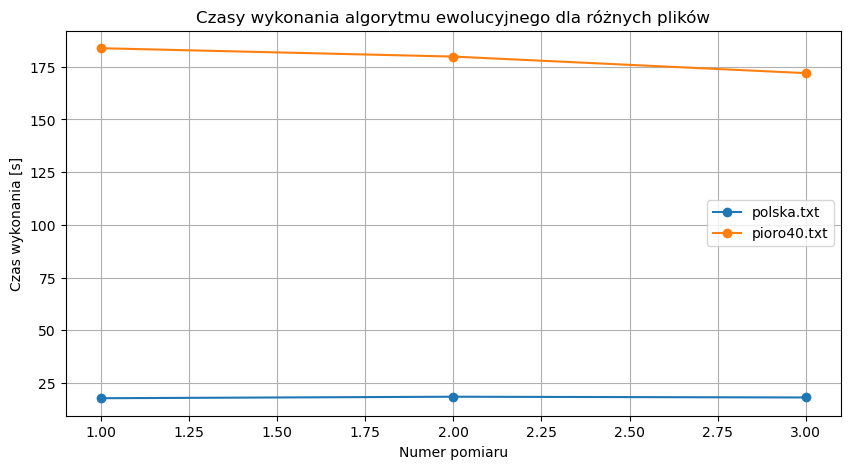

In [47]:
def measure_evolution_execution_time(measurements_count: int):
    parser_poland = SNDlibParser("polska.txt")
    parser_poland.parse()
    parser_pioro40 = SNDlibParser("pioro40.txt")
    parser_pioro40.parse()

    poland_times = []
    pioro40_times = []
    for _ in range(measurements_count):
        start_time = time.time()
        evolution(max_transponders_per_link=200, iterations=100, population_size=1000, parser=parser_poland, tournament_size=2, mutation_rate=0.05, mutation_strength=0.4, elite_size=10)
        end_time = time.time()
        poland_times.append(end_time - start_time)

        start_time = time.time()
        evolution(max_transponders_per_link=2500, iterations=10, population_size=1000, parser=parser_pioro40, tournament_size=2, mutation_rate=0.05, mutation_strength=0.4, elite_size=10)
        end_time = time.time()
        pioro40_times.append(end_time - start_time)

    avg_poland_time = sum(poland_times) / measurements_count
    avg_pioro40_time = sum(pioro40_times) / measurements_count

    print(f"\nŚredni czas wykonania dla pliku polska.txt: {avg_poland_time:.2f} sekund")
    print(f"Czasy wykonania dla pliku polska.txt: {[f'{t:.2f}' for t in poland_times]} sekund")
    print(f"Średni czas wykonania dla pliku pioro40.txt: {avg_pioro40_time:.2f} sekund")
    print(f"Czasy wykonania dla pliku pioro40.txt: {[f'{t:.2f}' for t in pioro40_times]} sekund")

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, measurements_count+1), poland_times, marker='o', label='polska.txt')
    plt.plot(range(1, measurements_count+1), pioro40_times, marker='o', label='pioro40.txt')
    plt.xlabel("Numer pomiaru")
    plt.ylabel("Czas wykonania [s]")
    plt.title("Czasy wykonania algorytmu ewolucyjnego dla różnych plików")
    plt.legend()
    plt.grid(True)
    plt.show()

measure_evolution_execution_time(measurements_count=3)

### Wniosek
Czasy wykonania dla tej samej sieci są bardzo zbliżone, co ma sens ponieważ czynniki silnie wpływające na złożoność obliczeniową - rozmiar populacji czy wykonywane kroki pozostają stałe dla każdego wywołania.

Wielokrotna różnica między sieciami spowodowana jest o wiele większą złożonością sieci pioro40. Posiada ona dużo więcej krawędzi, węzłów, żądań itp. więc każdy krok ewolucji jest obciążony znaczącą dodatkową porcją danych do przetworzenia.

## Wpływ rozmiaru turnieju na jakość rozwiązania

Poniższy test analizuje wpływ rozmiaru turnieju w selekcji turniejowej na jakość rozwiązań generowanych przez algorytm ewolucyjny. Dla zadanych wartości rozmiaru turnieju `torunament_size` algorytm jest uruchamiany jednokrotnie dla dwóch różnych instancji problemu: polska.txt oraz pioro40.txt.

Wyniki prezentowane są w formie tekstowej oraz na wykresie.


Wyniki dla pliku polska.txt:
Rozmiar turnieju: 2, Najlepsze przystosowanie: 3074.0
Rozmiar turnieju: 5, Najlepsze przystosowanie: 3000.0
Rozmiar turnieju: 20, Najlepsze przystosowanie: 3048.0
Rozmiar turnieju: 100, Najlepsze przystosowanie: 3022.0

Wyniki dla pliku pioro40.txt:
Rozmiar turnieju: 2, Najlepsze przystosowanie: 44718.0
Rozmiar turnieju: 5, Najlepsze przystosowanie: 44038.0
Rozmiar turnieju: 20, Najlepsze przystosowanie: 44042.0
Rozmiar turnieju: 100, Najlepsze przystosowanie: 44514.0


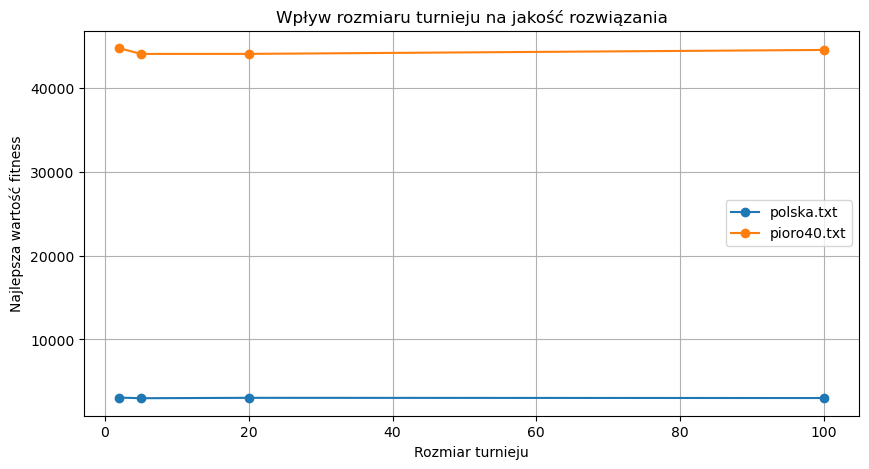

In [46]:
def measure_evolution_efficiency_for_different_tournament_sizes(tournament_sizes: List[int]):
    parser_poland = SNDlibParser("polska.txt")
    parser_poland.parse()
    parser_pioro40 = SNDlibParser("pioro40.txt")
    parser_pioro40.parse()

    results_poland = {}
    results_pioro40 = {}

    for tournament_size in tournament_sizes:
        best_individual, fitness_poland = evolution(max_transponders_per_link=200, iterations=100, population_size=1000, parser=parser_poland, tournament_size=tournament_size, mutation_rate=0.05, mutation_strength=0.4, elite_size=10)
        results_poland[tournament_size] = fitness_poland

        best_individual, fitness_pioro40 = evolution(max_transponders_per_link=2500, iterations=10, population_size=1000, parser=parser_pioro40, tournament_size=tournament_size, mutation_rate=0.05, mutation_strength=0.4, elite_size=10)
        results_pioro40[tournament_size] = fitness_pioro40

    print("\nWyniki dla pliku polska.txt:")
    for ts, fitness in results_poland.items():
        print(f"Rozmiar turnieju: {ts}, Najlepsze przystosowanie: {fitness}")

    print("\nWyniki dla pliku pioro40.txt:")
    for ts, fitness in results_pioro40.items():
        print(f"Rozmiar turnieju: {ts}, Najlepsze przystosowanie: {fitness}")

    plt.figure(figsize=(10, 5))
    plt.plot(list(results_poland.keys()), list(results_poland.values()), marker='o', label='polska.txt')
    plt.plot(list(results_pioro40.keys()), list(results_pioro40.values()), marker='o', label='pioro40.txt')
    plt.xlabel("Rozmiar turnieju")
    plt.ylabel("Najlepsza wartość fitness")
    plt.title("Wpływ rozmiaru turnieju na jakość rozwiązania")
    plt.legend()
    plt.grid(True)
    plt.show()

measure_evolution_efficiency_for_different_tournament_sizes(tournament_sizes=[2, 5, 20, 100])


## Wpływ współczynnika mutacji na jakość rozwiązania

Poniższy test bada wpływ wartości współczynnika mutacji na jakość rozwiązań generowanych przez algorytm ewolucyjny. Algorytm uruchamiany jest jednokrotnie dla różnych wartości parametru `mutation_rate` dla dwóch instancji problemu: polska.txt oraz pioro40.txt.

Wyniki prezentowane są w formie tekstowej oraz na wykresie.


Wyniki dla pliku polska.txt:
Współczynnik mutacji: 0.05, Najlepsze przystosowanie: 3082.0
Współczynnik mutacji: 0.3, Najlepsze przystosowanie: 3304.0
Współczynnik mutacji: 0.5, Najlepsze przystosowanie: 3248.0
Współczynnik mutacji: 1.0, Najlepsze przystosowanie: 3392.0

Wyniki dla pliku pioro40.txt:
Współczynnik mutacji: 0.05, Najlepsze przystosowanie: 44444.0
Współczynnik mutacji: 0.3, Najlepsze przystosowanie: 44570.0
Współczynnik mutacji: 0.5, Najlepsze przystosowanie: 45096.0
Współczynnik mutacji: 1.0, Najlepsze przystosowanie: 44812.0


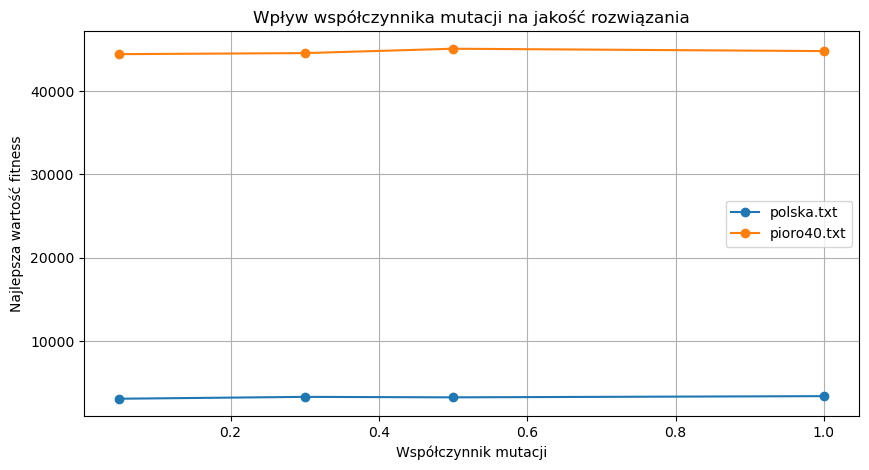

In [45]:
def measure_evolution_efficiency_for_different_mutation_rates(mutation_rates: List[float]):
    parser_poland = SNDlibParser("polska.txt")
    parser_poland.parse()
    parser_pioro40 = SNDlibParser("pioro40.txt")
    parser_pioro40.parse()

    results_poland = {}
    results_pioro40 = {}

    for mutation_rate in mutation_rates:
        best_individual, fitness_poland = evolution(max_transponders_per_link=200, iterations=100, population_size=1000, parser=parser_poland, tournament_size=2, mutation_rate=mutation_rate, mutation_strength=0.4, elite_size=10)
        results_poland[mutation_rate] = fitness_poland

        best_individual, fitness_pioro40 = evolution(max_transponders_per_link=2500, iterations=10, population_size=1000, parser=parser_pioro40, tournament_size=2, mutation_rate=mutation_rate, mutation_strength=0.4, elite_size=10)
        results_pioro40[mutation_rate] = fitness_pioro40

    print("\nWyniki dla pliku polska.txt:")
    for mutation_rate, fitness in results_poland.items():
        print(f"Współczynnik mutacji: {mutation_rate}, Najlepsze przystosowanie: {fitness}")

    print("\nWyniki dla pliku pioro40.txt:")
    for mutation_rate, fitness in results_pioro40.items():
        print(f"Współczynnik mutacji: {mutation_rate}, Najlepsze przystosowanie: {fitness}")
        
    plt.figure(figsize=(10, 5))
    plt.plot(list(results_poland.keys()), list(results_poland.values()), marker='o', label='polska.txt')
    plt.plot(list(results_pioro40.keys()), list(results_pioro40.values()), marker='o', label='pioro40.txt')
    plt.xlabel("Współczynnik mutacji")
    plt.ylabel("Najlepsza wartość fitness")
    plt.title("Wpływ współczynnika mutacji na jakość rozwiązania")
    plt.legend()
    plt.grid(True)
    plt.show()

measure_evolution_efficiency_for_different_mutation_rates(mutation_rates=[0.05, 0.3, 0.5, 1.0])


## Wpływ siły mutacji na jakość rozwiązania

Poniższy test analizuje wpływ parametru siły mutacji `mutation_strength` na jakość rozwiązań generowanych przez algorytm ewolucyjny. Dla różnych wartości tego parametru algorytm uruchamiany jest jednokrotnie dla dwóch instancji problemu: polska.txt oraz pioro40.txt.

Wyniki prezentowane są w postaci tekstowej oraz na wykresie.


Wyniki dla pliku polska.txt:
Współczynnik siły mutacji: 0.4, Najlepsze przystosowanie: 3092.0
Współczynnik siły mutacji: 1.0, Najlepsze przystosowanie: 3354.0
Współczynnik siły mutacji: 2.0, Najlepsze przystosowanie: 3450.0
Współczynnik siły mutacji: 5.0, Najlepsze przystosowanie: 3372.0

Wyniki dla pliku pioro40.txt:
Współczynnik siły mutacji: 0.4, Najlepsze przystosowanie: 44528.0
Współczynnik siły mutacji: 1.0, Najlepsze przystosowanie: 44562.0
Współczynnik siły mutacji: 2.0, Najlepsze przystosowanie: 44498.0
Współczynnik siły mutacji: 5.0, Najlepsze przystosowanie: 44128.0


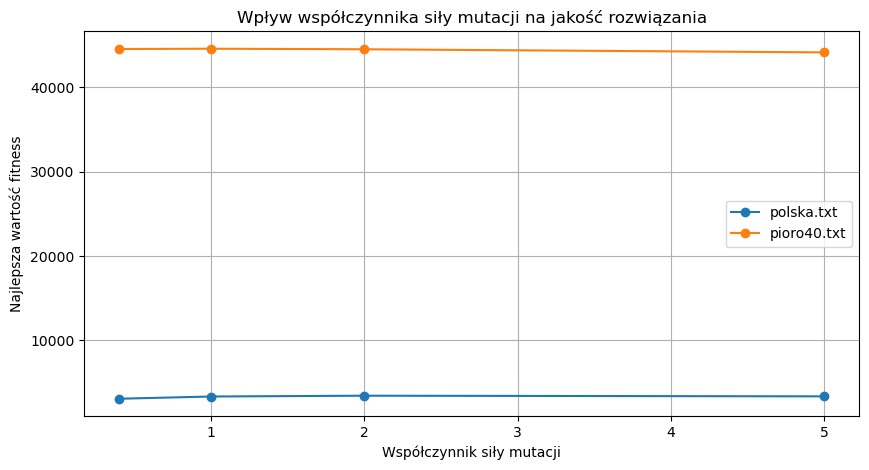

In [42]:
def measure_evolution_efficiency_for_different_mutation_strengths(mutation_strengths: List[float]):
    parser_poland = SNDlibParser("polska.txt")
    parser_poland.parse()
    parser_pioro40 = SNDlibParser("pioro40.txt")
    parser_pioro40.parse()

    results_poland = {}
    results_pioro40 = {}

    for mutation_strength in mutation_strengths:
        best_individual, fitness_poland = evolution(max_transponders_per_link=200, iterations=100, population_size=1000, parser=parser_poland, tournament_size=2, mutation_rate=0.05, mutation_strength=mutation_strength, elite_size=10)
        results_poland[mutation_strength] = fitness_poland

        best_individual, fitness_pioro40 = evolution(max_transponders_per_link=2500, iterations=10, population_size=1000, parser=parser_pioro40, tournament_size=2, mutation_rate=0.05, mutation_strength=mutation_strength, elite_size=10)
        results_pioro40[mutation_strength] = fitness_pioro40

    print("\nWyniki dla pliku polska.txt:")
    for mutation_strength, fitness in results_poland.items():
        print(f"Współczynnik siły mutacji: {mutation_strength}, Najlepsze przystosowanie: {fitness}")
    print("\nWyniki dla pliku pioro40.txt:")
    for mutation_strength, fitness in results_pioro40.items():
        print(f"Współczynnik siły mutacji: {mutation_strength}, Najlepsze przystosowanie: {fitness}")
        
    plt.figure(figsize=(10, 5))
    plt.plot(list(results_poland.keys()), list(results_poland.values()), marker='o', label='polska.txt')
    plt.plot(list(results_pioro40.keys()), list(results_pioro40.values()), marker='o', label='pioro40.txt')
    plt.xlabel("Współczynnik siły mutacji")
    plt.ylabel("Najlepsza wartość fitness")
    plt.title("Wpływ współczynnika siły mutacji na jakość rozwiązania")
    plt.legend()
    plt.grid(True)
    plt.show()

measure_evolution_efficiency_for_different_mutation_strengths(mutation_strengths=[0.4, 1.0, 2.0, 5.0])


## Wpływ wielkości elity na jakość rozwiązania

Poniższy test bada wpływ wielkości elity `elite_size` na jakość rozwiązań generowanych przez algorytm ewolucyjny. Dla różnych wartości tego parametru algorytm uruchamiany jest jednokrotnie dla dwóch instancji problemu: polska.txt oraz pioro40.txt.

Wyniki prezentowane są w formie tekstowej oraz na wykresie.


Wyniki dla pliku polska.txt:
Wielkość elity: 1, Najlepsze przystosowanie: 3122.0
Wielkość elity: 10, Najlepsze przystosowanie: 3066.0
Wielkość elity: 20, Najlepsze przystosowanie: 3126.0
Wielkość elity: 50, Najlepsze przystosowanie: 3038.0

Wyniki dla pliku pioro40.txt:
Wielkość elity: 1, Najlepsze przystosowanie: 44162.0
Wielkość elity: 10, Najlepsze przystosowanie: 44390.0
Wielkość elity: 20, Najlepsze przystosowanie: 43816.0
Wielkość elity: 50, Najlepsze przystosowanie: 44728.0


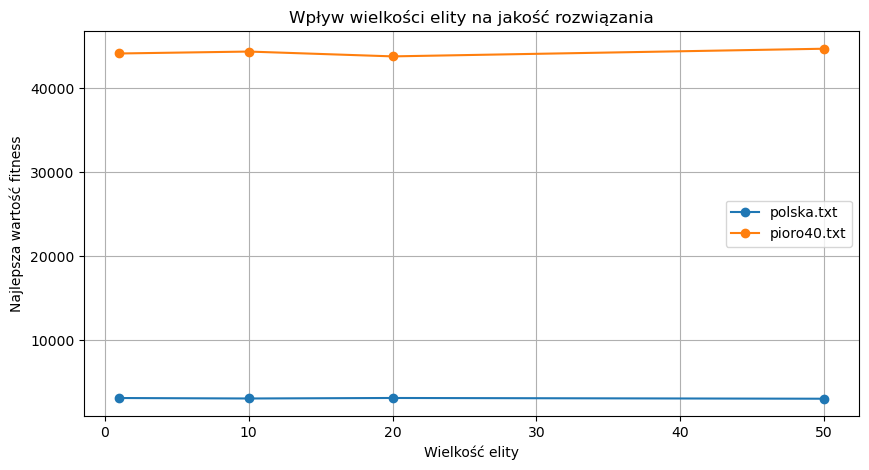

In [44]:
def measure_evolution_efficiency_for_different_elite_sizes(elite_sizes: List[int]):
    parser_poland = SNDlibParser("polska.txt")
    parser_poland.parse()
    parser_pioro40 = SNDlibParser("pioro40.txt")
    parser_pioro40.parse()

    results_poland = {}
    results_pioro40 = {}

    for elite_size in elite_sizes:
        best_individual, fitness_poland = evolution(max_transponders_per_link=200, iterations=100, population_size=1000, parser=parser_poland, tournament_size=2, mutation_rate=0.05, mutation_strength=0.4, elite_size=elite_size)
        results_poland[elite_size] = fitness_poland

        best_individual, fitness_pioro40 = evolution(max_transponders_per_link=2500, iterations=10, population_size=1000, parser=parser_pioro40, tournament_size=2, mutation_rate=0.05, mutation_strength=0.4, elite_size=elite_size)
        results_pioro40[elite_size] = fitness_pioro40

    print("\nWyniki dla pliku polska.txt:")
    for elite_size, fitness in results_poland.items():
        print(f"Wielkość elity: {elite_size}, Najlepsze przystosowanie: {fitness}")
    print("\nWyniki dla pliku pioro40.txt:")
    for elite_size, fitness in results_pioro40.items():
        print(f"Wielkość elity: {elite_size}, Najlepsze przystosowanie: {fitness}")
        
    plt.figure(figsize=(10, 5))
    plt.plot(list(results_poland.keys()), list(results_poland.values()), marker='o', label='polska.txt')
    plt.plot(list(results_pioro40.keys()), list(results_pioro40.values()), marker='o', label='pioro40.txt')
    plt.xlabel("Wielkość elity")
    plt.ylabel("Najlepsza wartość fitness")
    plt.title("Wpływ wielkości elity na jakość rozwiązania")
    plt.legend()
    plt.grid(True)
    plt.show()

measure_evolution_efficiency_for_different_elite_sizes(elite_sizes=[1, 10, 20, 50])


## Wpływ wartości parametru lambda (maksymalna ilość par transponderów korzystających z jednej krawędzi) na jakość rozwiązania

Poniższy test analizuje wpływ wartości parametru lambda (przekazywanego jako `max_transponders_per_link`) na jakość rozwiązań generowanych przez algorytm ewolucyjny. Parametr ten ogranicza maksymalną liczbę transponderów na pojedynczej krawędzi, a tym samym wpływa na dopuszczalność i koszt rozwiązań. Testowane wartości lambda zostały dobrane tak, aby najmniejsza z nich dopuszczała sensowną ilość rozwiązań dla danej sieci.

Dla różnych wartości lambda algorytm uruchamiany jest jednokrotnie osobno dla dwóch instancji problemu: polska.txt oraz pioro40.txt. Dla każdej wartości zapisywana jest najlepsza uzyskana wartość funkcji przystosowania.

Wyniki prezentowane są w formie tekstowej oraz graficznej na wykresie liniowym.


Wyniki dla pliku polska.txt:
Wartość lambda: 200, Najlepsze przystosowanie: 3102.0
Wartość lambda: 400, Najlepsze przystosowanie: 3178.0
Wartość lambda: 600, Najlepsze przystosowanie: 3118.0

Wyniki dla pliku pioro40.txt:
Wartość lambda: 2500, Najlepsze przystosowanie: 44278.0
Wartość lambda: 5000, Najlepsze przystosowanie: 44540.0
Wartość lambda: 7500, Najlepsze przystosowanie: 43730.0


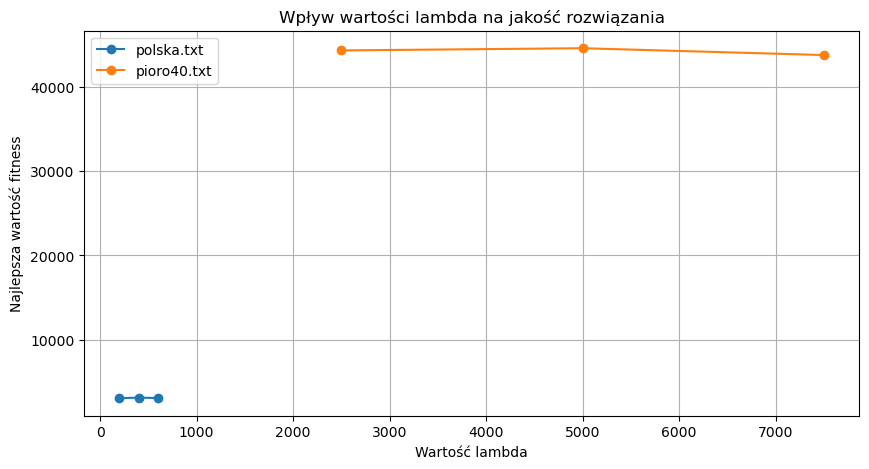

In [43]:
def measure_evolution_efficiency_for_different_lambda(lambda_values_poland: List[float], lambda_values_pioro40: List[float]):
    parser_poland = SNDlibParser("polska.txt")
    parser_poland.parse()
    parser_pioro40 = SNDlibParser("pioro40.txt")
    parser_pioro40.parse()

    results_poland = {}
    results_pioro40 = {}

    for lambda_value in lambda_values_poland:
        best_individual, fitness_poland = evolution(max_transponders_per_link=lambda_value, iterations=100, population_size=1000, parser=parser_poland, tournament_size=2, mutation_rate=0.05, mutation_strength=0.4, elite_size=10)
        results_poland[lambda_value] = fitness_poland

    for lambda_value in lambda_values_pioro40:
        best_individual, fitness_pioro40 = evolution(max_transponders_per_link=lambda_value, iterations=10, population_size=1000, parser=parser_pioro40, tournament_size=2, mutation_rate=0.05, mutation_strength=0.4, elite_size=10)
        results_pioro40[lambda_value] = fitness_pioro40

    print("\nWyniki dla pliku polska.txt:")
    for lambda_value, fitness in results_poland.items():
        print(f"Wartość lambda: {lambda_value}, Najlepsze przystosowanie: {fitness}")
    print("\nWyniki dla pliku pioro40.txt:")
    for lambda_value, fitness in results_pioro40.items():
        print(f"Wartość lambda: {lambda_value}, Najlepsze przystosowanie: {fitness}")
        
    plt.figure(figsize=(10, 5))
    plt.plot(list(results_poland.keys()), list(results_poland.values()), marker='o', label='polska.txt')
    plt.plot(list(results_pioro40.keys()), list(results_pioro40.values()), marker='o', label='pioro40.txt')
    plt.xlabel("Wartość lambda")
    plt.ylabel("Najlepsza wartość fitness")
    plt.title("Wpływ wartości lambda na jakość rozwiązania")
    plt.legend()
    plt.grid(True)
    plt.show()

measure_evolution_efficiency_for_different_lambda(lambda_values_poland=[200, 400, 600], lambda_values_pioro40=[2500, 5000, 7500])

## Wnioski z przeprowadzonyh eksperymentów

Na podstawie przeprowadzonych eksperymentów można zauważyć, że dla obu sieci (rozbudowanej i prostej) oraz dla różnych wartości analizowanych parametrów (takich jak współczynnik mutacji, siła mutacji, rozmiar turnieju, wielkość elity czy parametr lambda) jakość uzyskiwanych rozwiązań pozostaje na zbliżonym poziomie. Oznacza to, że wyniki ewolucji są stabilne i algorytm dąży do podobnych optimów. Stabilność może wynikać z zastosowanych nakierowań przy generacji populacji - np. określenie maksymalnej ilości transponderów. Dzięki nim algorytm ma większe szanse na dotarcie do sensownych wyników, co jak pokazują eksperymenty, czyni dla różnych wartości parametrów wywołania. Zmieniane parametry, mimo że wpływają na szczegóły przebiegu ewolucji, nie powodują istotnych zaburzeń drogi do optimum, dlatego algorytm konsekwentnie zbiega do podobnych jakościowo rozwiązań.

Należy jednak pamiętać, że przestrzeń rozwiązań jest gigantyczna i niemożliwa do objęcia ludzkim umysłem więc nie jest możliwe jednoznaczne sprawdzenie, czy znalezione rozwiązanie jest tym najlepszym, korzystając tylko z algorytmu ewolucyjnego. Jest on obarczony ogromnym wpływem losowości i nie bada całej przestrzeni rozwiązań. Powinien on zatem służyć do eksperymentalnego wytworzenia kandydatów na najlepsze rozwiązanie, które następnie należy dopracować, tak aby tam gdzie to możliwe zmniejszyć koszty rozstawienia sieci. Ta potrzeba jest szczególnie widoczna przy w sekcji `Demonstracja działania` gdzie przykładowo dla jednego z żądań została podana ilość 5 transpondera typu 4 (200 jednostek / 12 kosztu), co znacznie przekracza jakąkolwiek wartość zapotrzebowania sieci. Algorytm dokonując losowej ewolucji mógłby się tego problemu pozbyć w przyszłych iteracjach lub zupełnie odwrotnie mógłby np. w procesie mutacji zwiększyć ilość tych transponderów doprowadzając do jeszcze gorszego kosztu na tej ścieżce, jednocześnie sumarycznie dając lepszy wynik na innych ścieżkach. Janso pokazuje to, że rozwiązania zwracane przez algorytm ewolucyjny są blisko optimum ale nie są idealne i wymagają deterministycznej poprawy - np. poprzez ludzką ręczną poprawę lub przy użyciu deterministycznego algorytmu optymalizującego zwróconego osobnika. 

Można tym samym uznać algorytm ewolucyjny za bardzo przydatne narzędzie do przeszukiwania ogromnej przestrzeni rozwiązań. Jest w stanie podać dobrych kandydatów na rozwiązanie problemu optymalizacji. Nie jest ono jednak bez wad - dla skomplikowanych problemów szanse na zwrócenie definitywnie najlepszego rozwiązania są bardzo niskie i jest to trudne do zweryfikowania.